In [21]:
import glob
import pandas as pd
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

# Leading SPACE!!!
angle_type_prefix = ' pose_R'
angle_type_prefix = ' p_r'

# angle_type = angle_type_prefix + 'x'
# head_class = 'nod'
# width_threshold = 2.18
# height_threshold = 0.0032

FILTER_KERNEL = 9 # 7 or 9 si max
FRAME_RATE = 30

def get_peaks_params(head_class, angle_type, derivative):
    
    all_widths = []
    all_heights = []
    avg_w = []
    avg_h = []

    # CHANGE PATH!!!
    for csv_file in glob.glob('./data/' + head_class + '/*.csv'):
        df = pd.read_csv(csv_file)

        # Resample to common frame rate
        csv_frame_rate = (df.shape[0] - 1) / np.sum(np.diff(df[' timestamp']))
        # print('csv frame rate: ', csv_frame_rate)
        n_resampled_points = int(1 + (len(df[angle_type]) - 1) * FRAME_RATE / csv_frame_rate)
        angles = scipy.signal.resample(df[angle_type], num=n_resampled_points)
        
        angles = np.diff(angles)

        # Filter
        angles_filt = scipy.signal.medfilt(angles, kernel_size=FILTER_KERNEL)

#         fc = 3
#         b, a = scipy.signal.butter(N=2, Wn=2*fc/FRAME_RATE, btype='low', analog=False, output='ba')
    #     angles_filt = scipy.signal.filtfilt(b, a, angles)

        # Get peak locations
        pos_peaks, _ = scipy.signal.find_peaks(angles_filt)
        neg_peaks, _ = scipy.signal.find_peaks(-angles_filt)

        curr_w = []
        curr_h = []
        # Detect neighboring +- and -+
        i, j = 0, 0
        while i < len(pos_peaks) and j < len(neg_peaks):
            all_widths.append(abs(pos_peaks[i] - neg_peaks[j]))
            all_heights.append(angles_filt[pos_peaks[i]] - angles_filt[neg_peaks[j]])
            
            curr_w.append(all_widths[-1])
            curr_h.append(all_heights[-1])
            
            # + -
            if pos_peaks[i] < neg_peaks[j]:
                i += 1
            # - +
            elif pos_peaks[i] > neg_peaks[j]:
                j += 1
            else:
                raise Exception('Postive and negative peaks coincide!')
                
        # If no peaks found and it is other class, add zero peak
        if len(curr_w) == 0:
            if head_class == 'other':
                avg_w.append(0)
                avg_h.append(0)
                all_widths.append(0)
                all_heights.append(0)
        else:
            avg_w.append(np.mean(curr_w))
            avg_h.append(np.mean(curr_h))

        # Plot
        plt.figure(figsize=(14, 4))
        
        plt.plot(angles, 'k-o', label='original')
        plt.plot(angles_filt, 'orange', label='filtered')
        
        for p in pos_peaks:
            plt.axvline(p, color='red')
        for p in neg_peaks:
            plt.axvline(p, color='blue')
    #     plt.tight_layout(h_pad=-4.9)
        plt.legend()
        plt.xlim(0, 200)
        plt.show()
    #     break

    return all_widths, all_heights, avg_w, avg_h


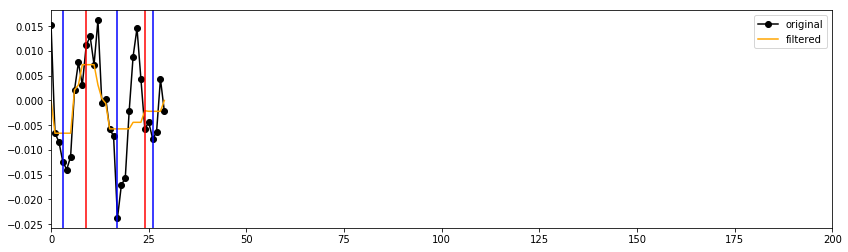

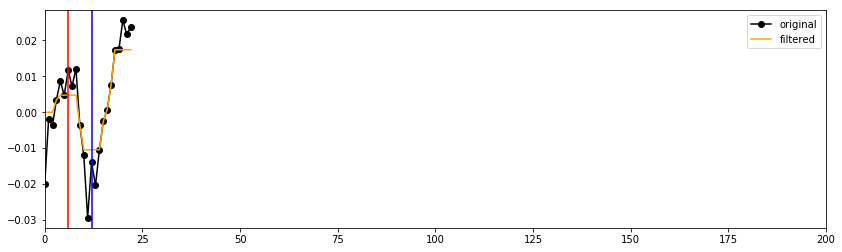

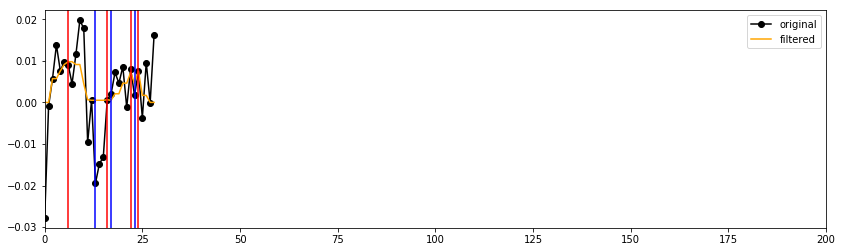

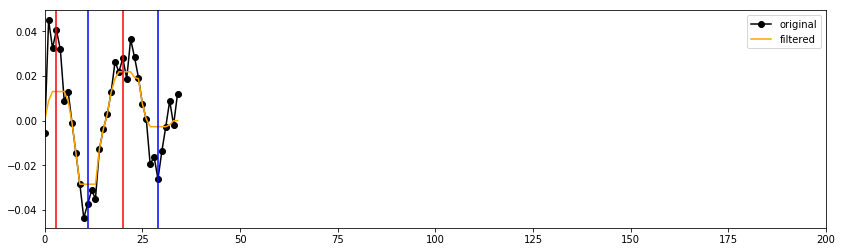

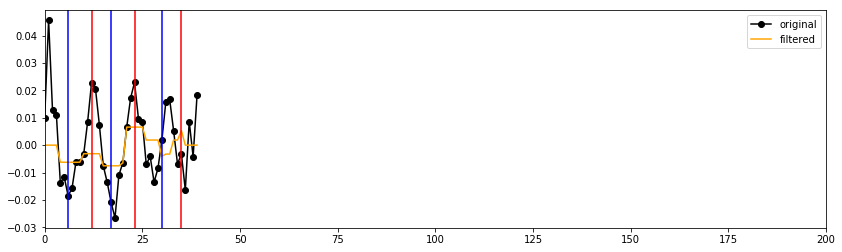

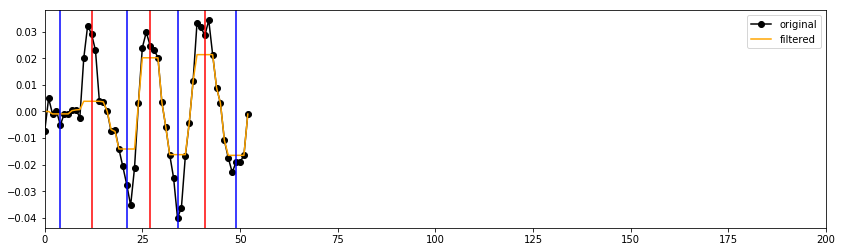

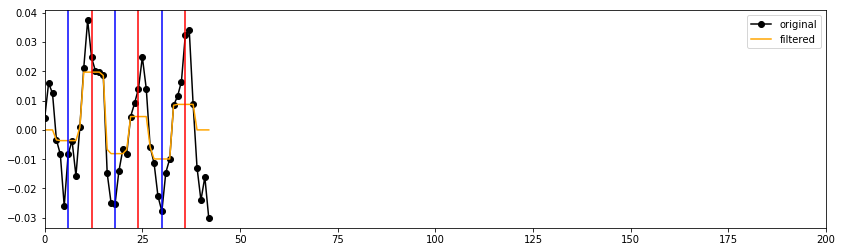

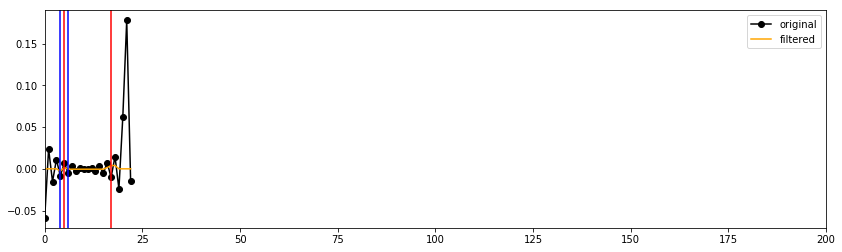

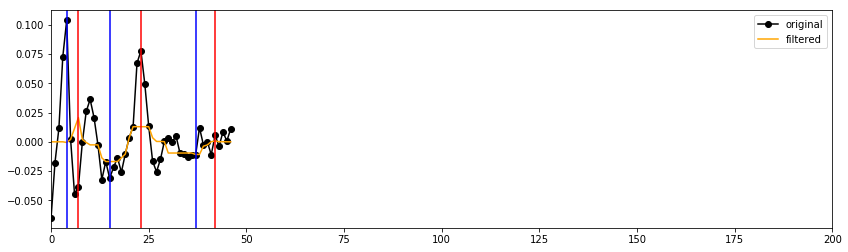

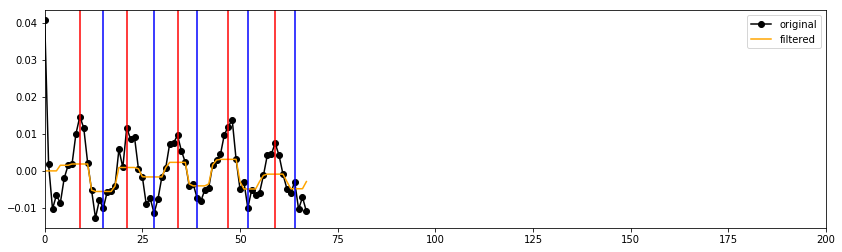

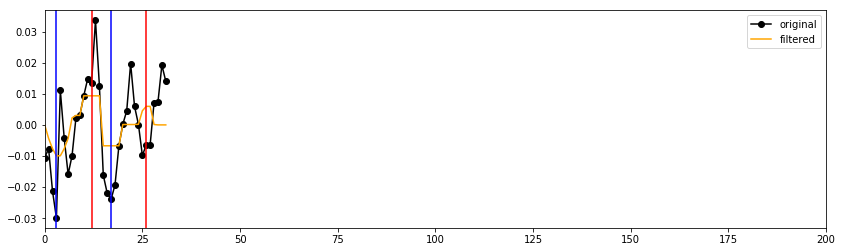

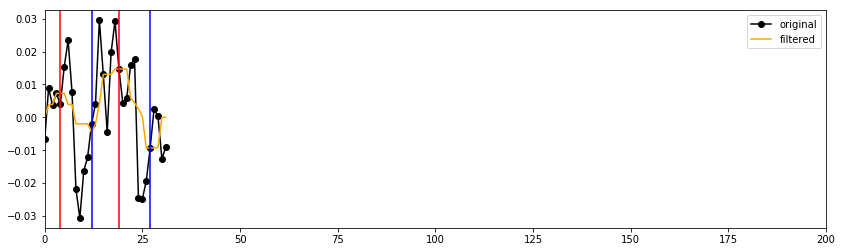

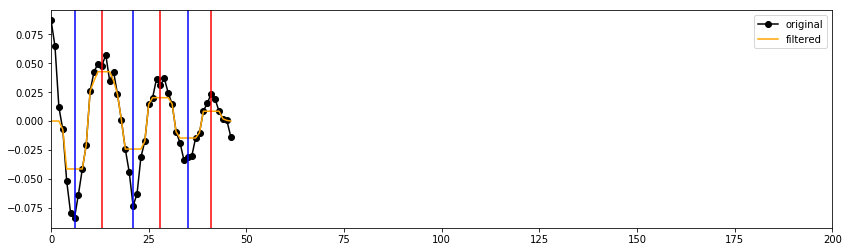

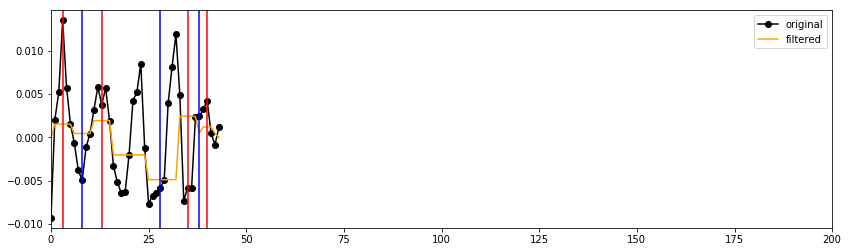

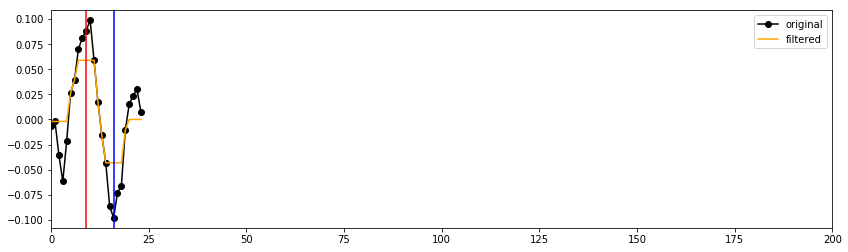

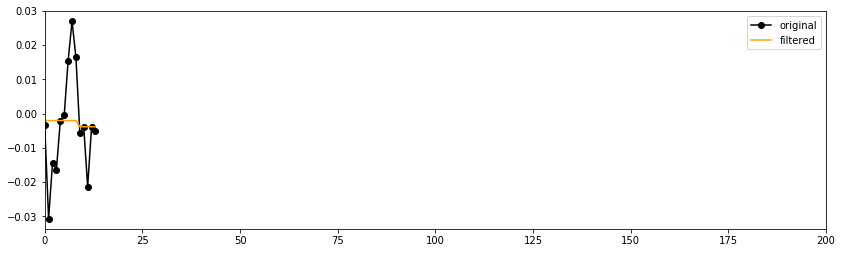

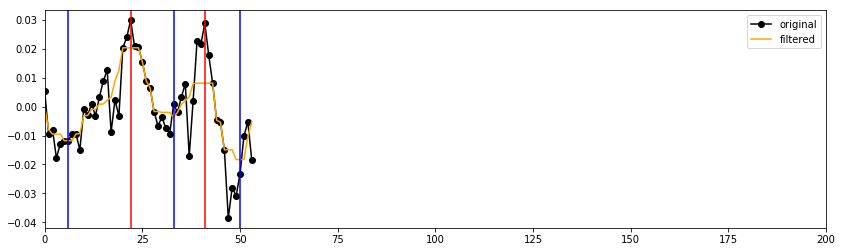

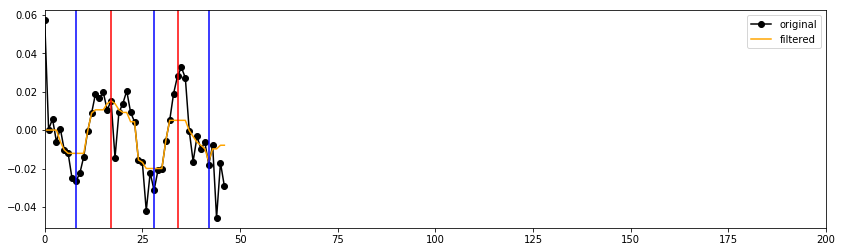

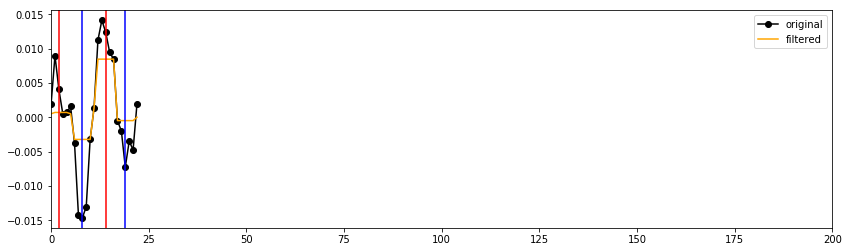

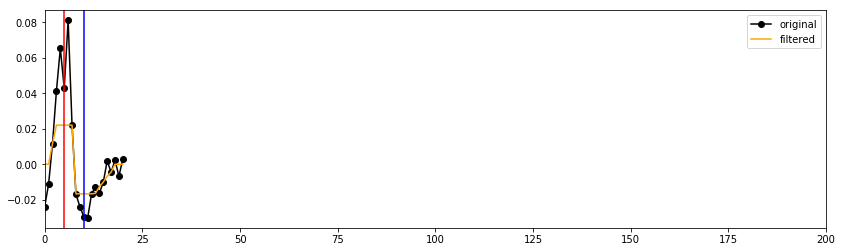

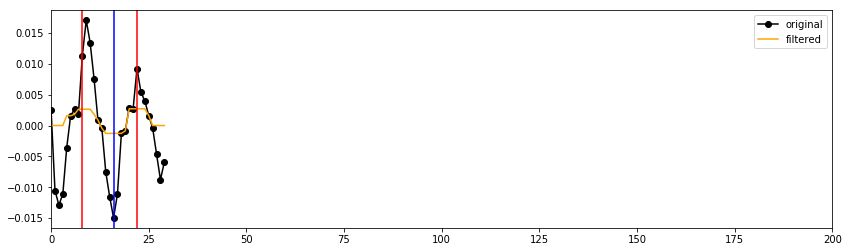

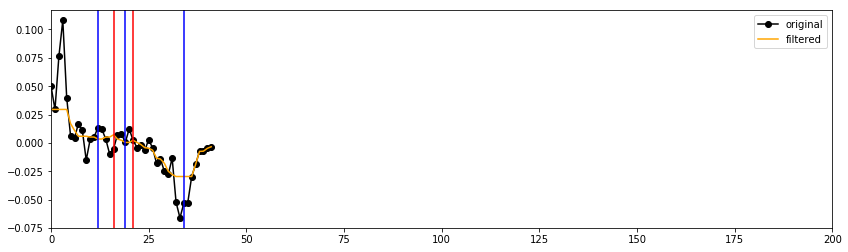

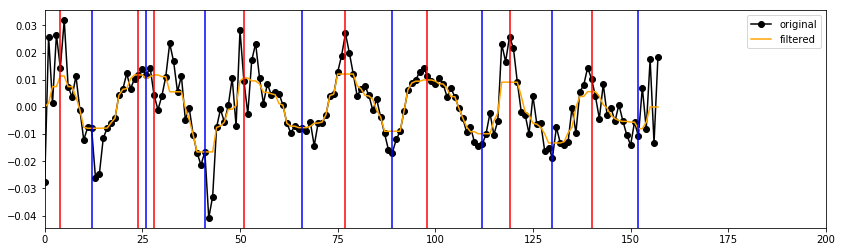

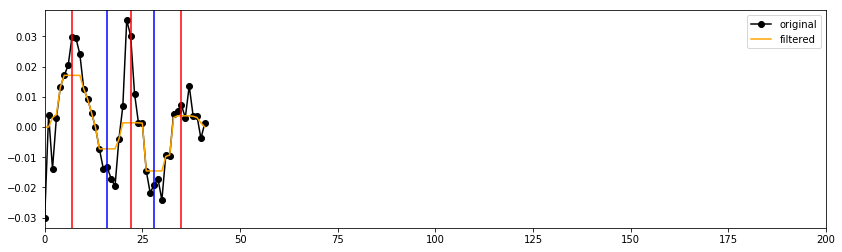

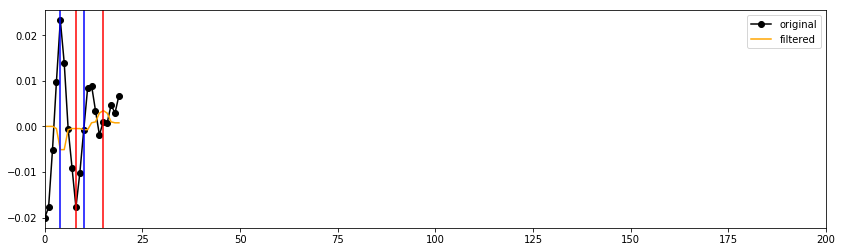

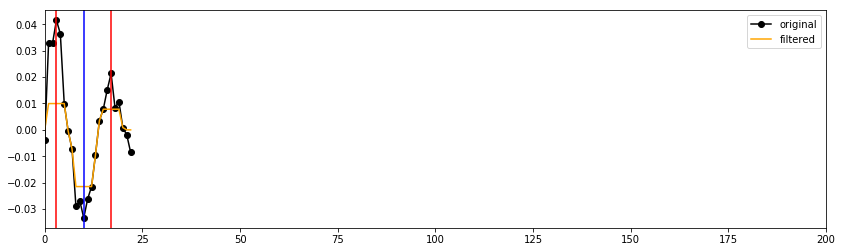

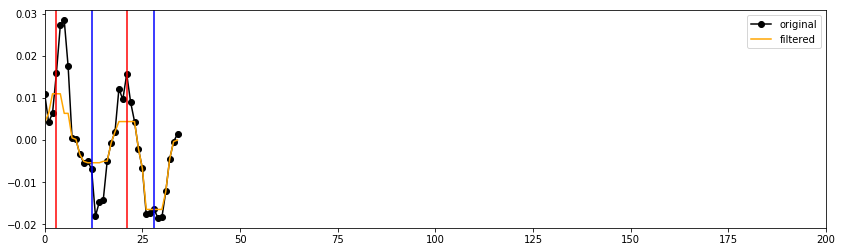

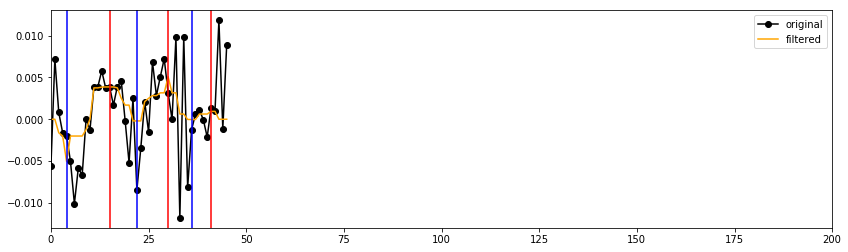

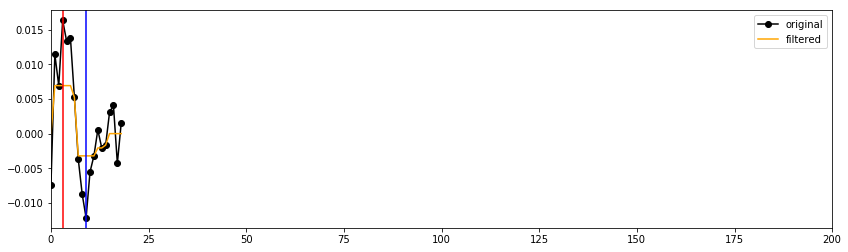

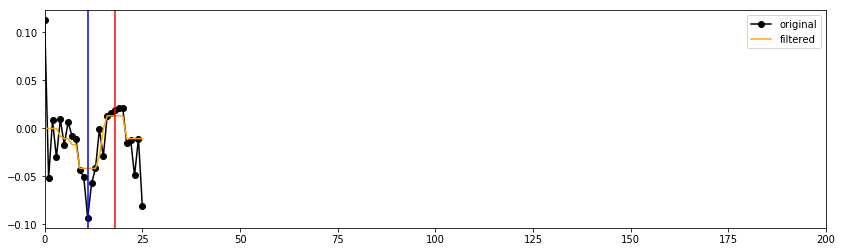

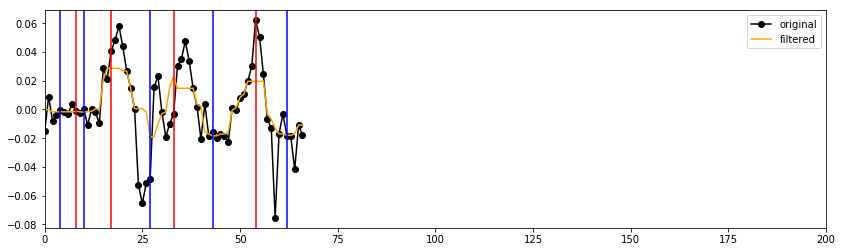

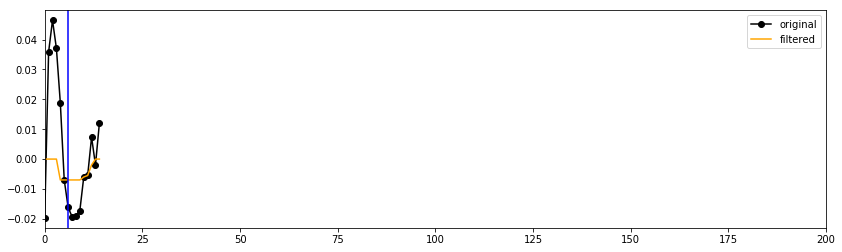

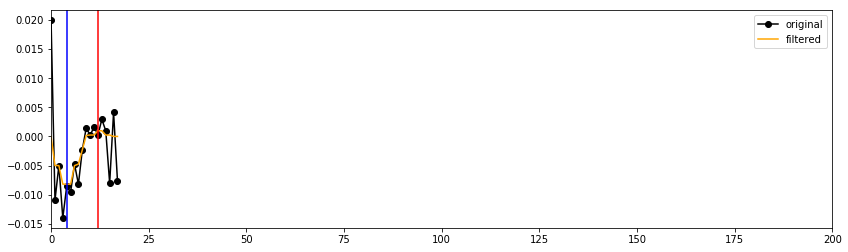

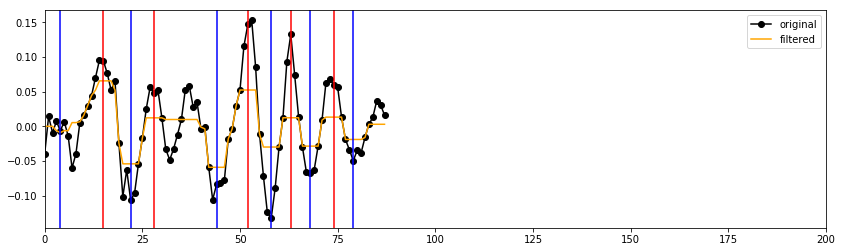

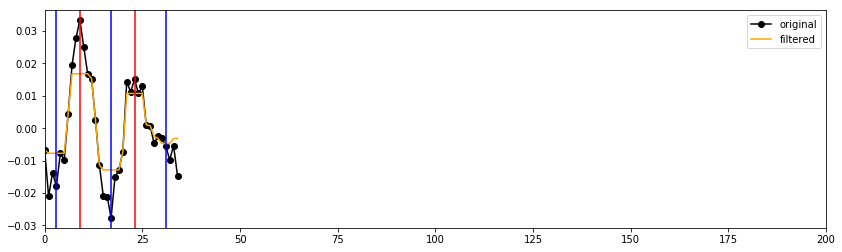

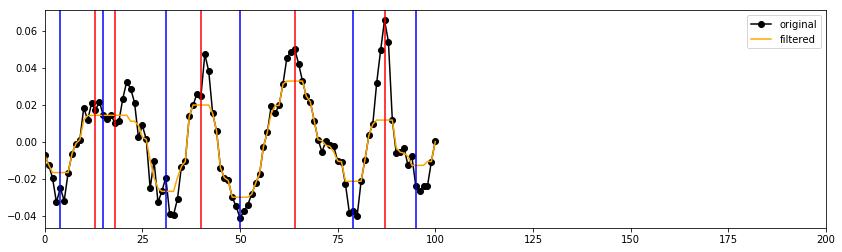

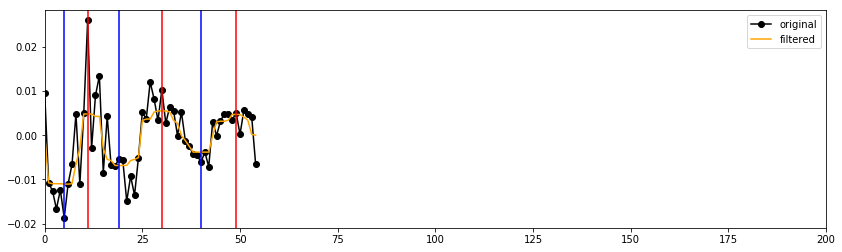

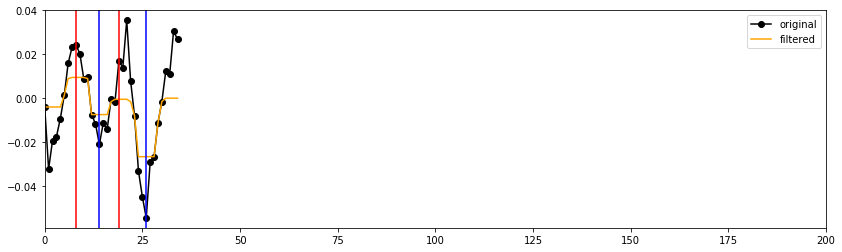

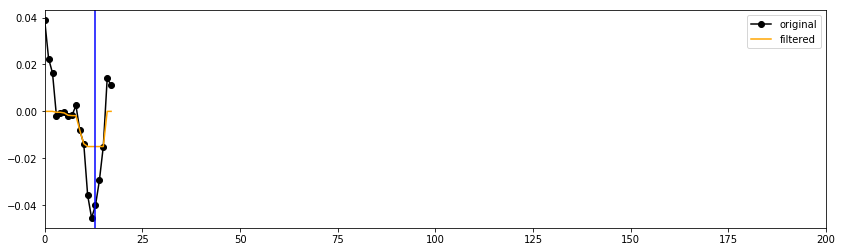

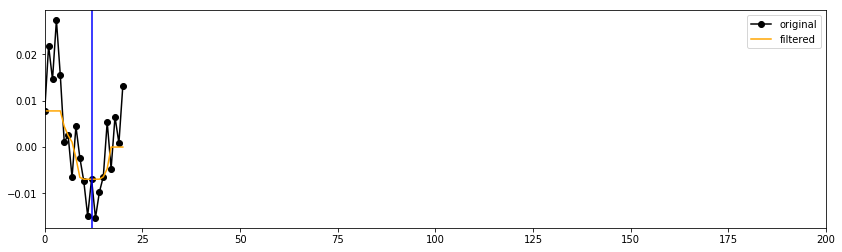

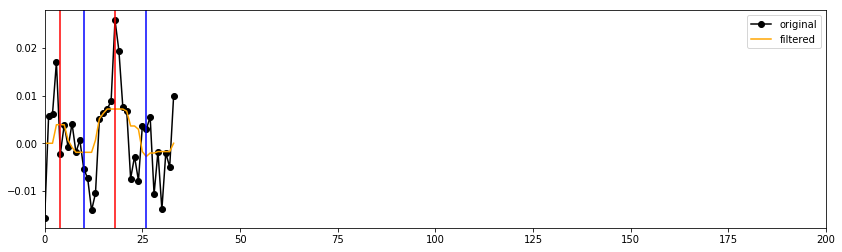

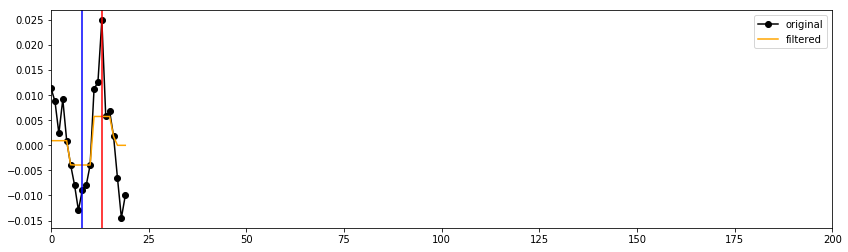

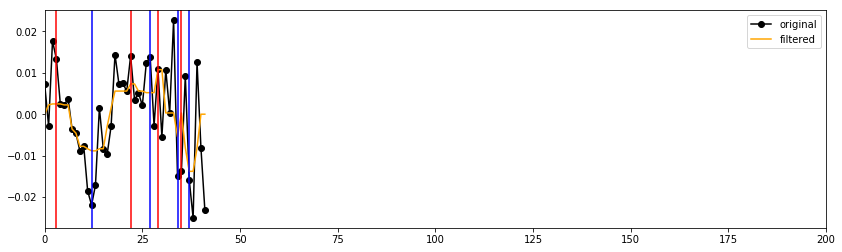

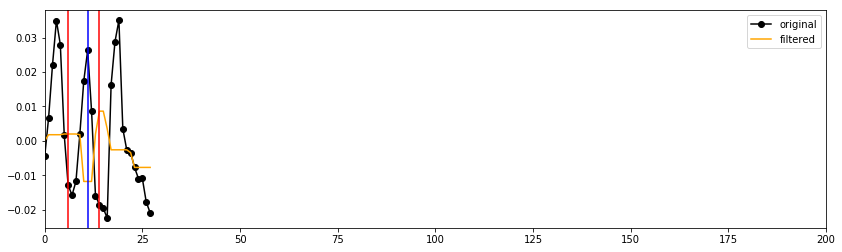

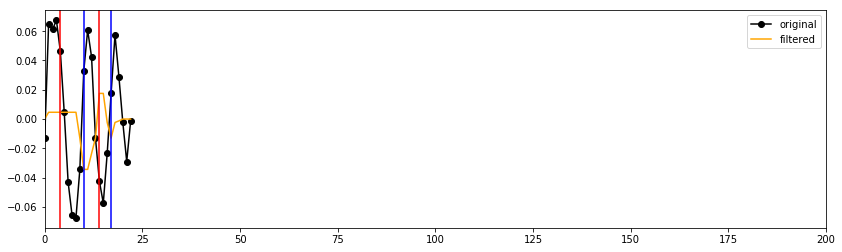

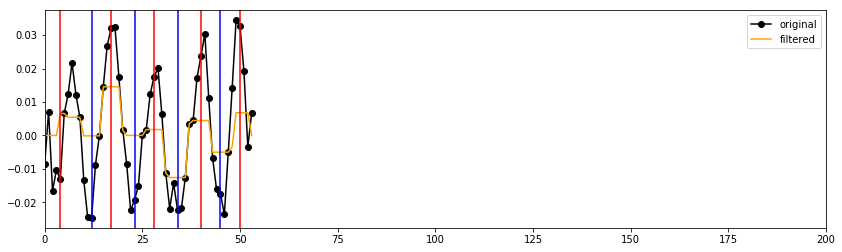

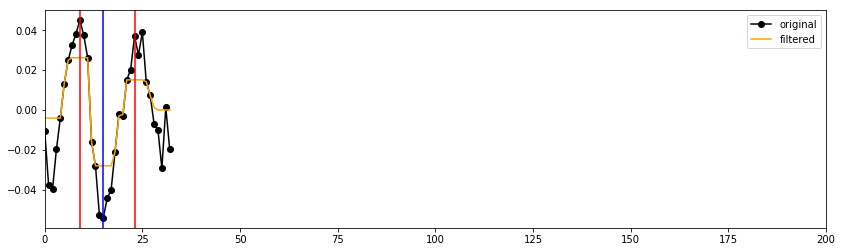

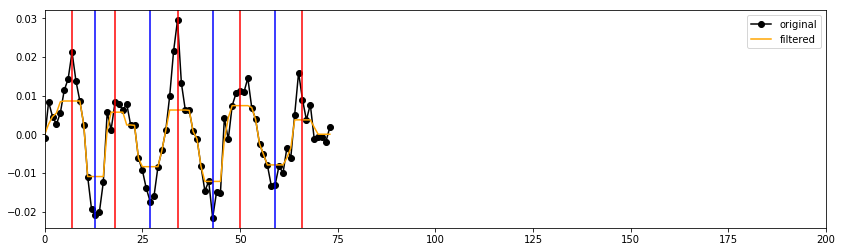

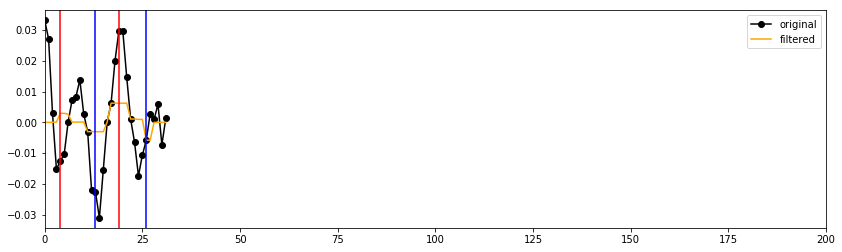

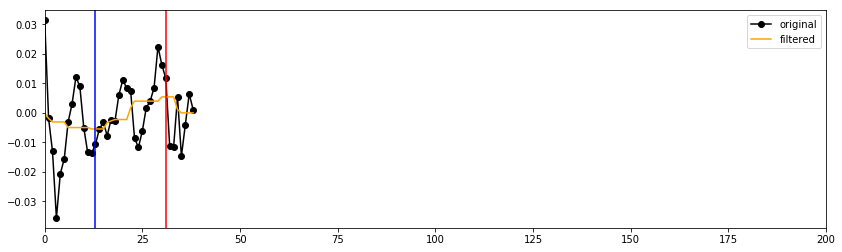

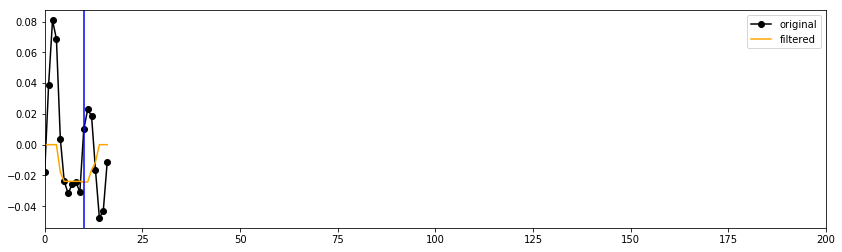

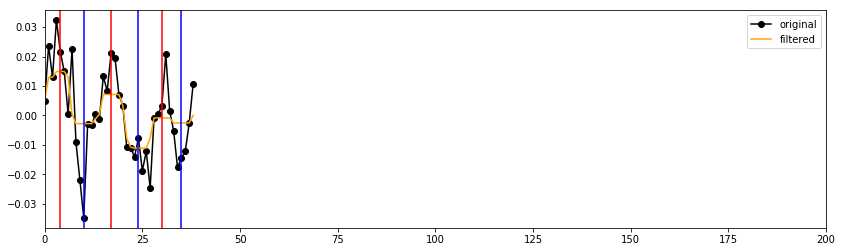

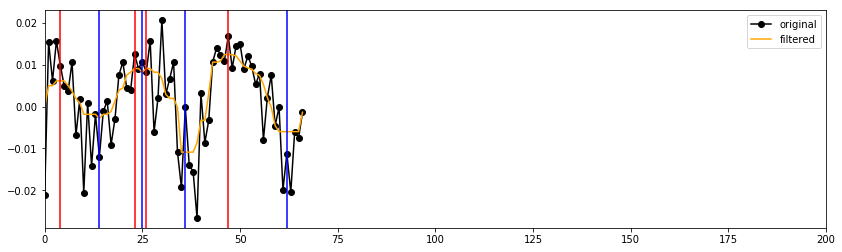

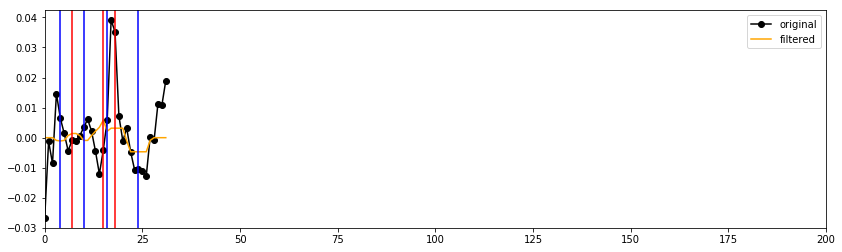

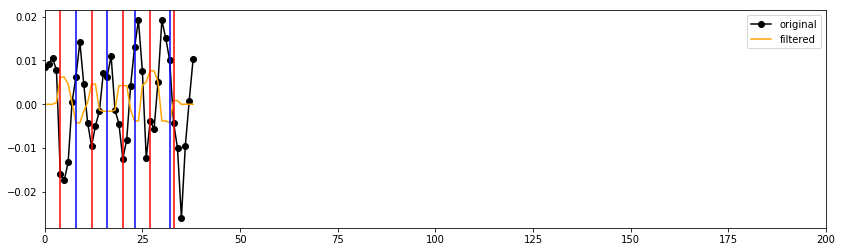

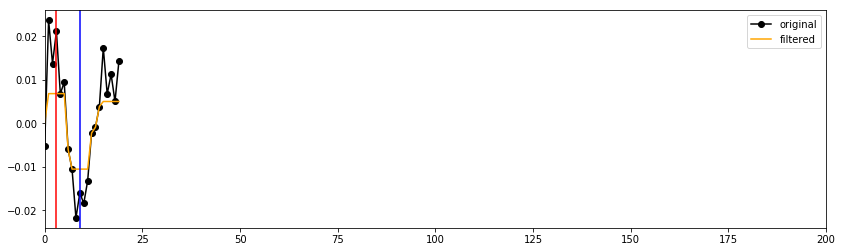

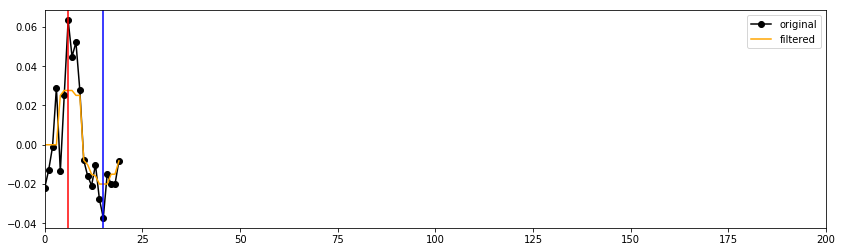

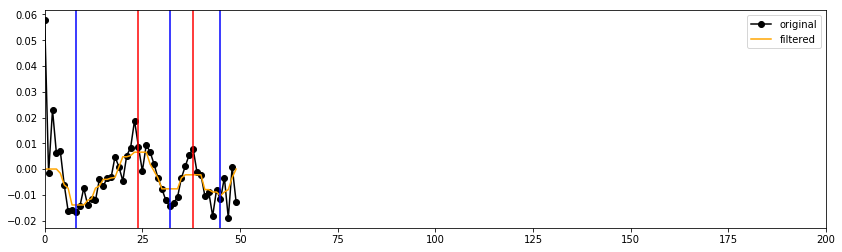

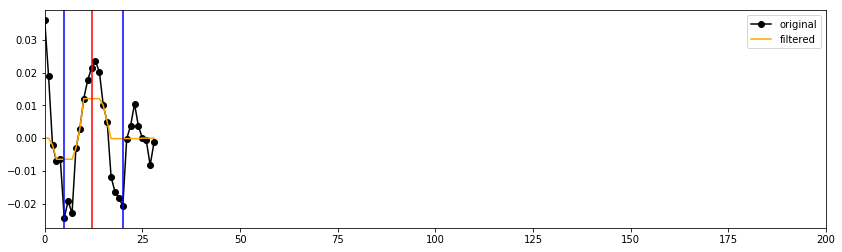

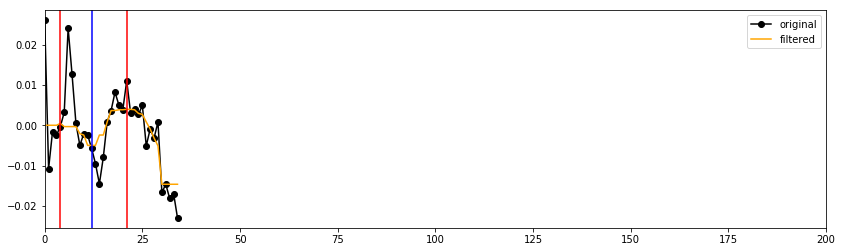

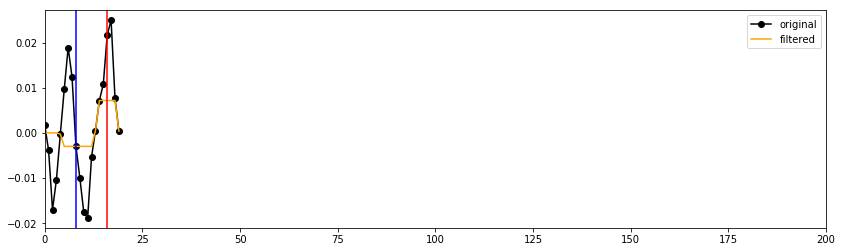

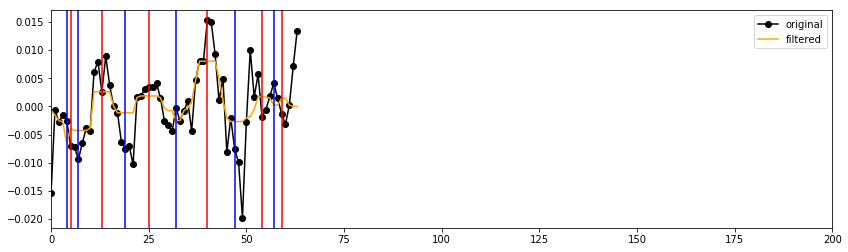

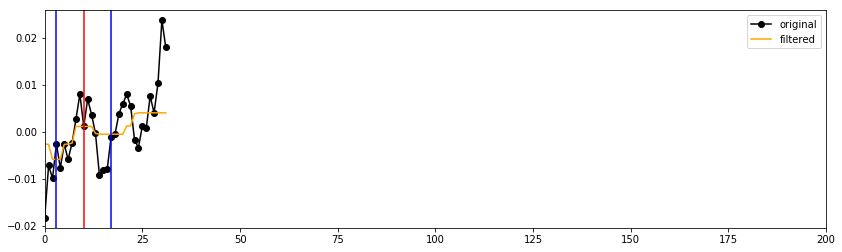

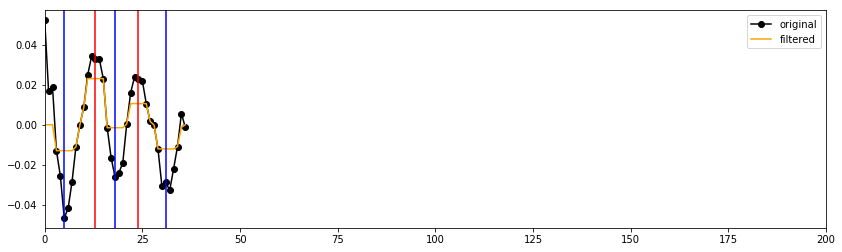

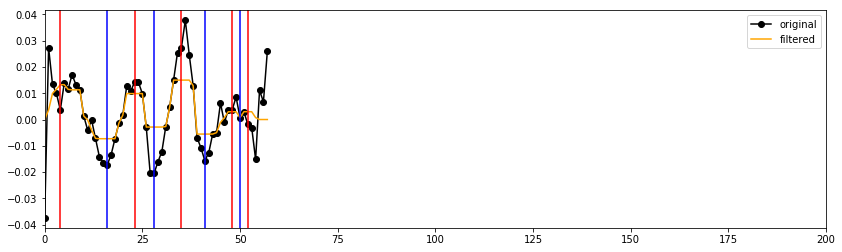

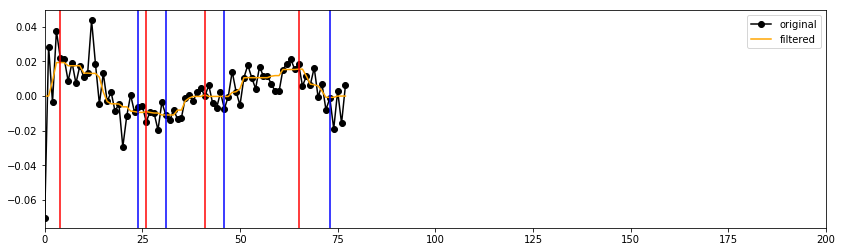

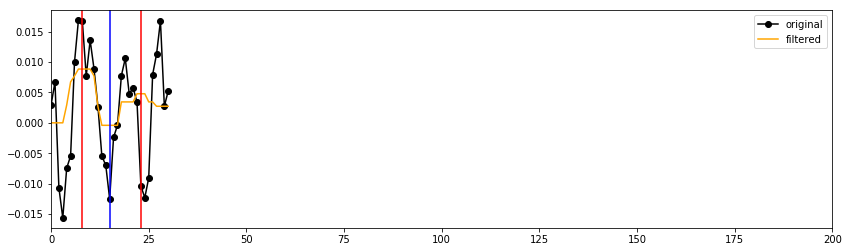

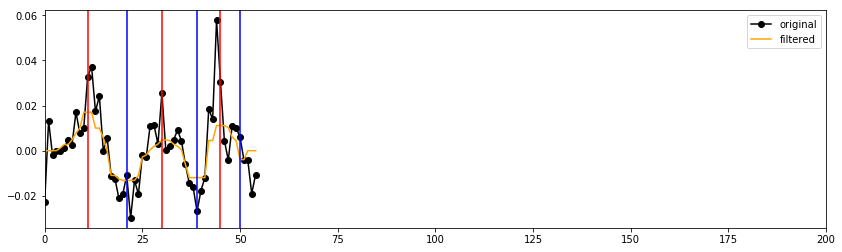

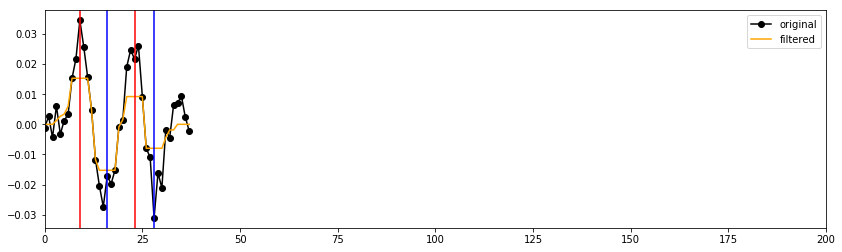

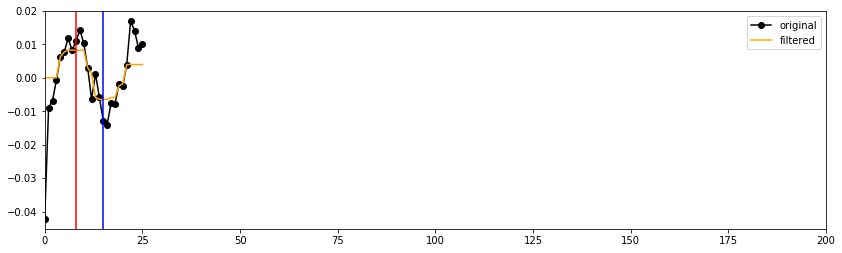

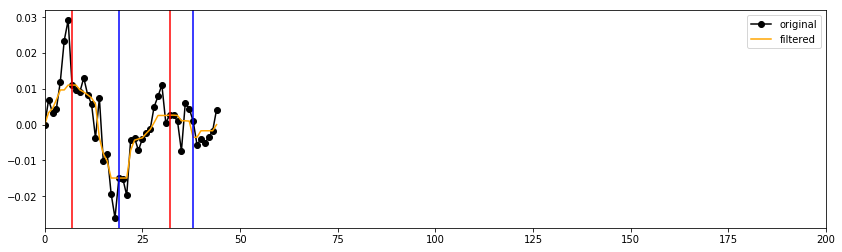

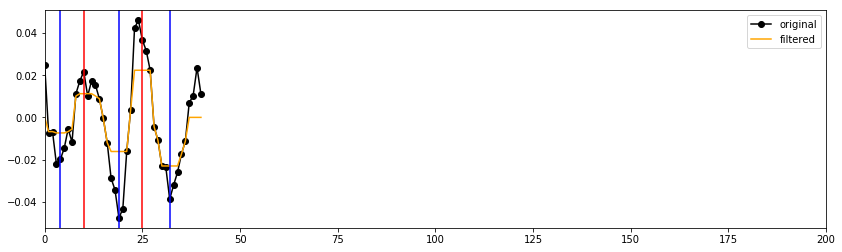

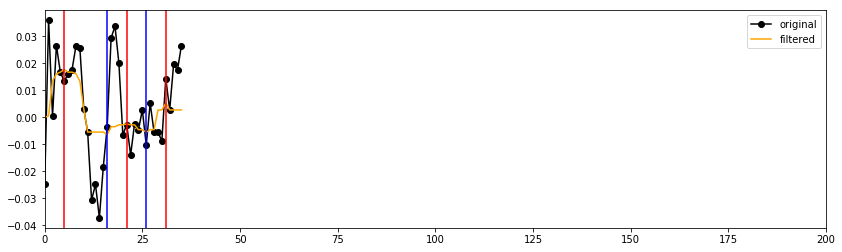

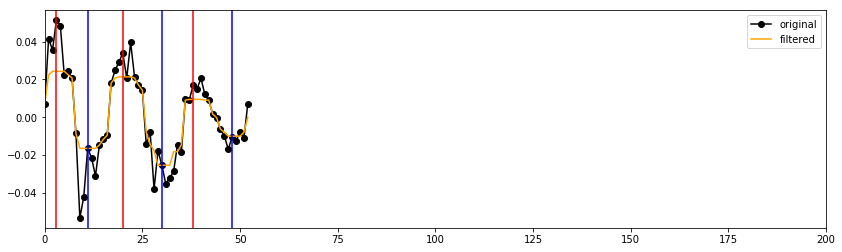

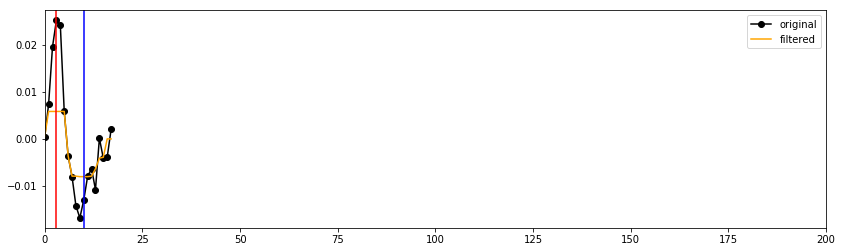

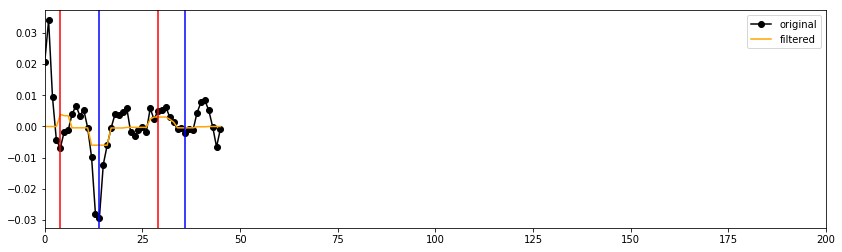

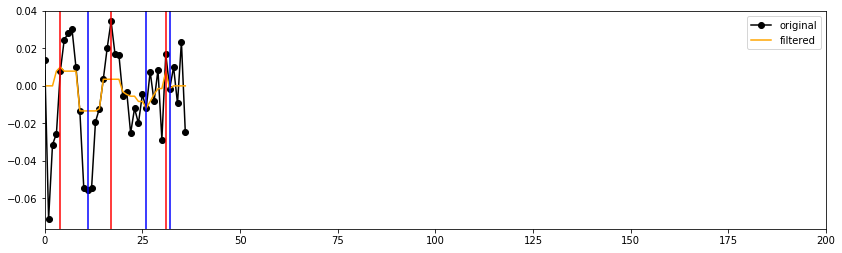

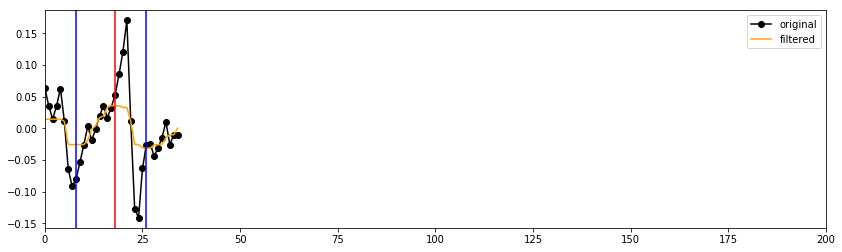

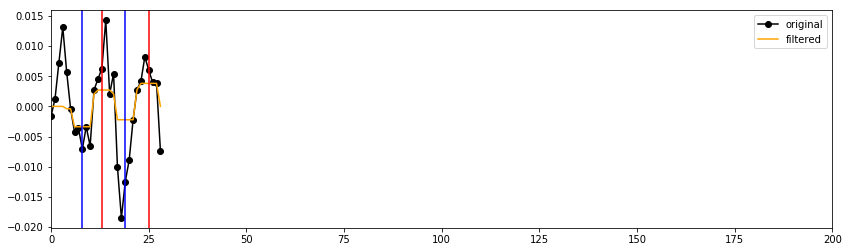

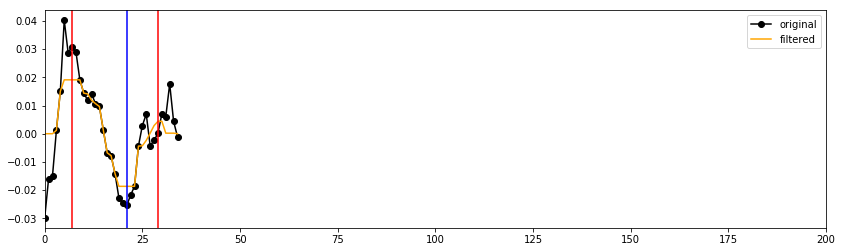

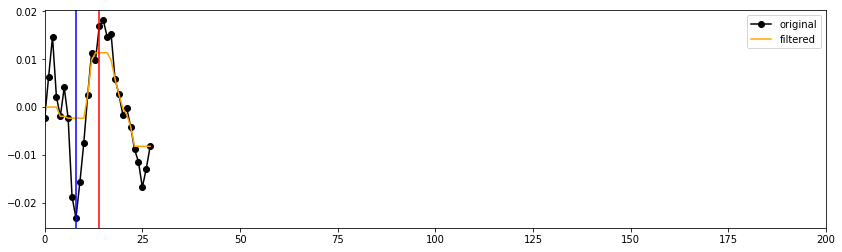

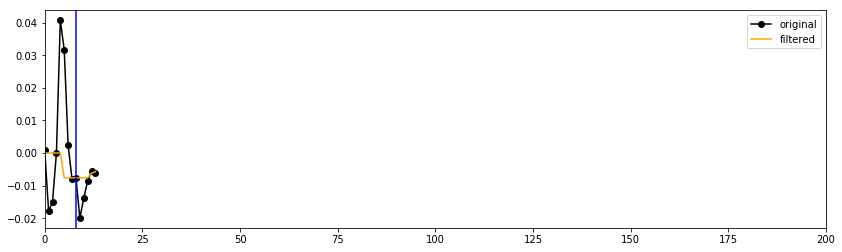

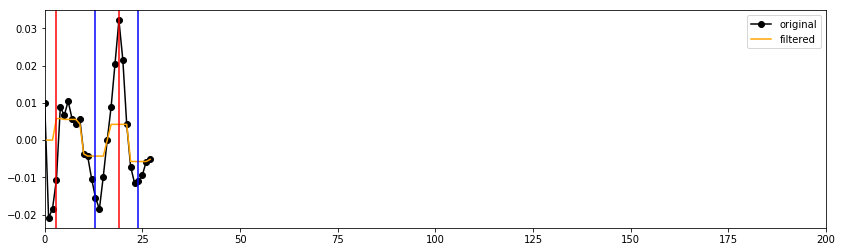

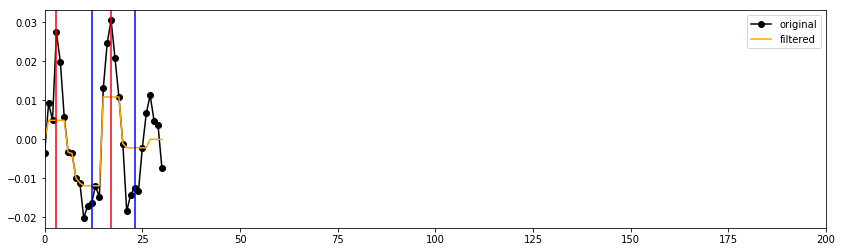

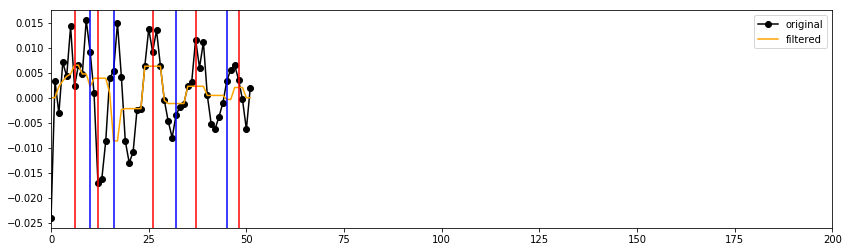

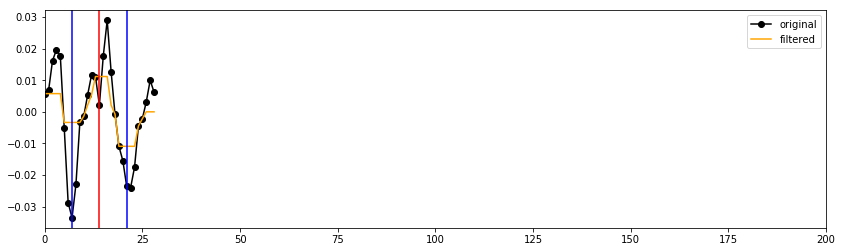

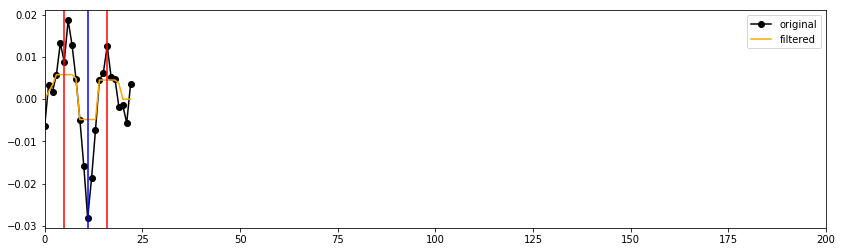

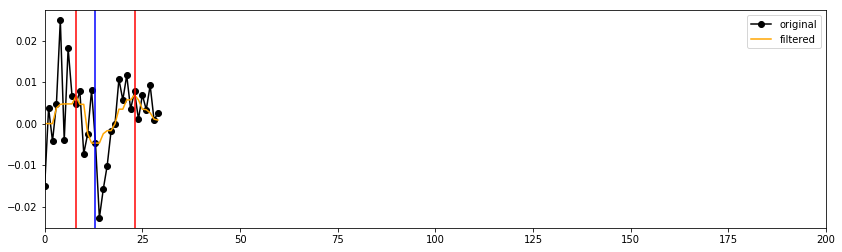

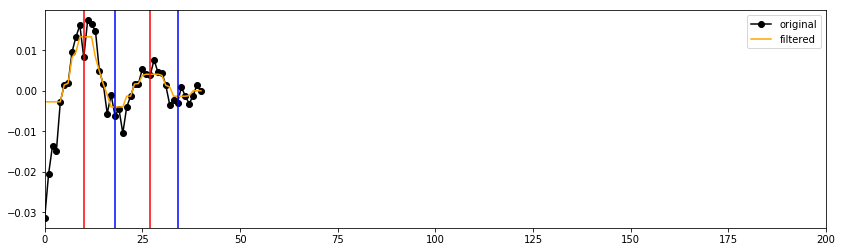

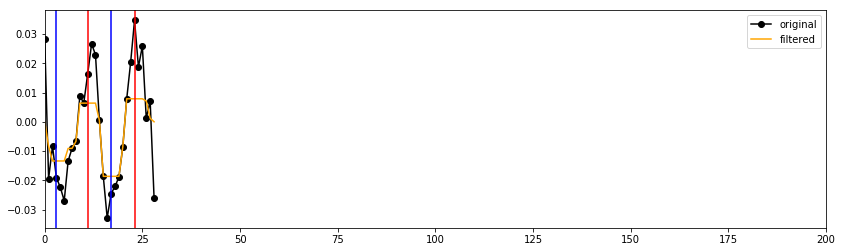

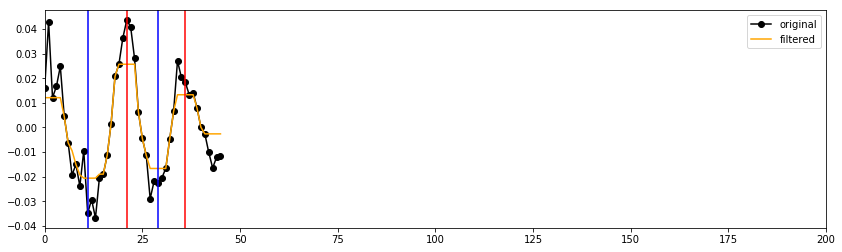

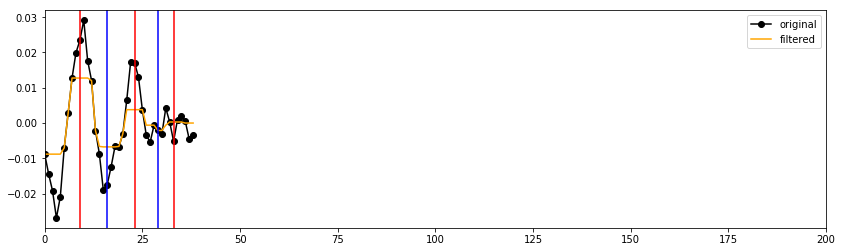

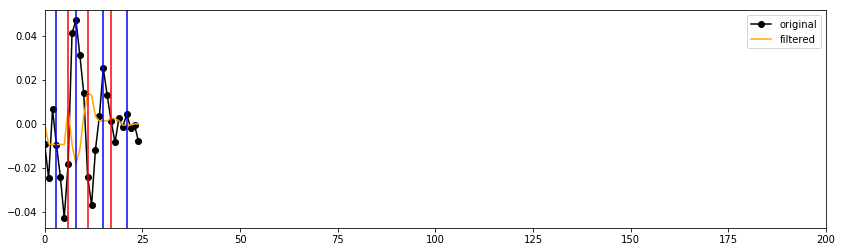

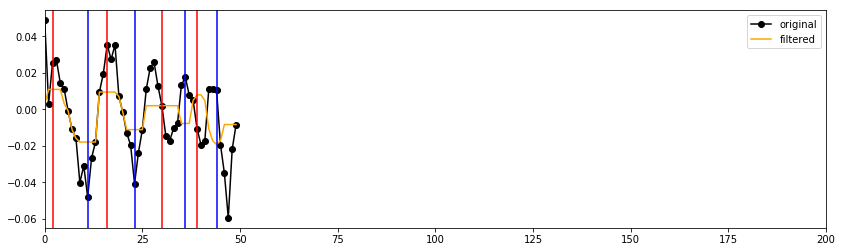

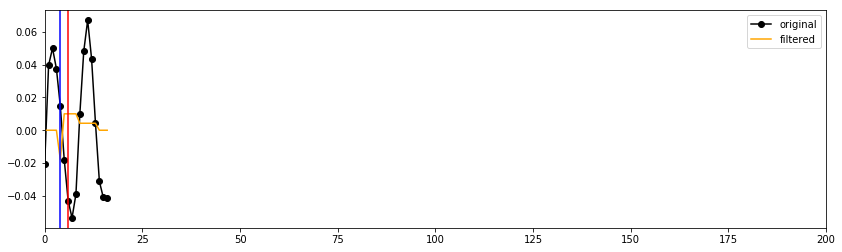

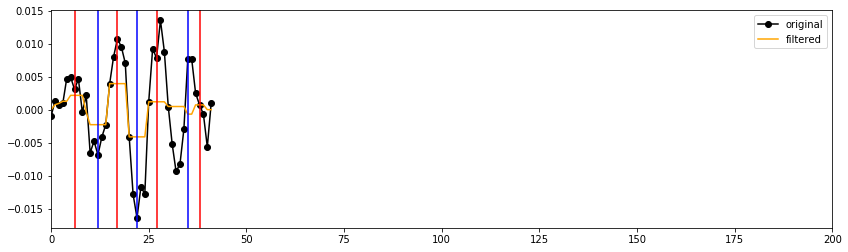

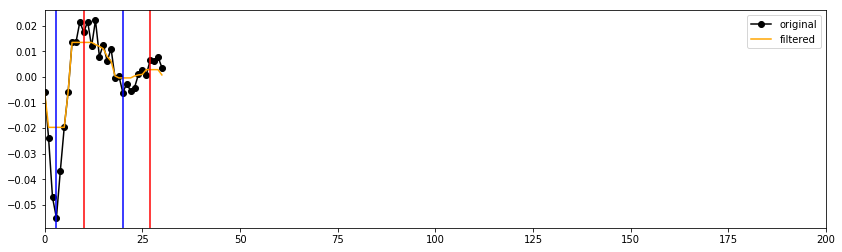

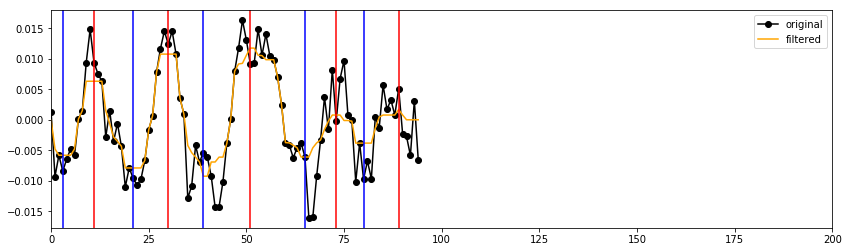

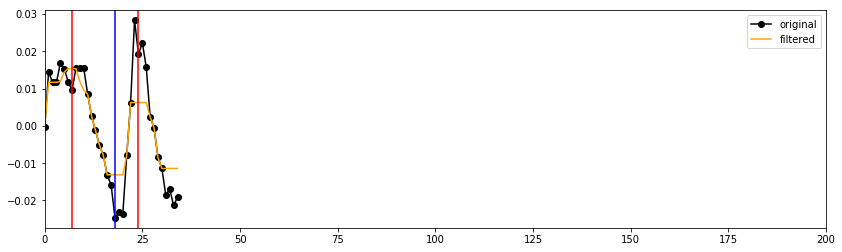

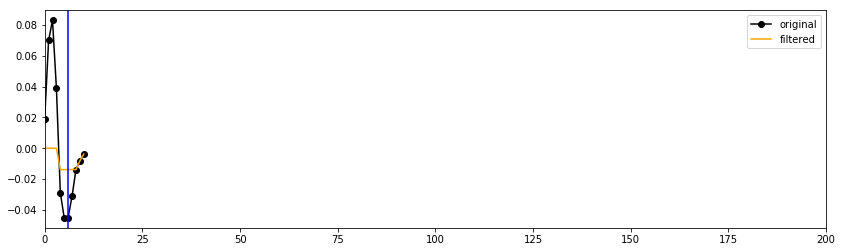

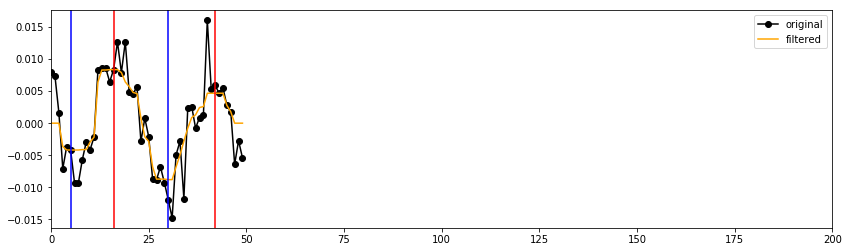

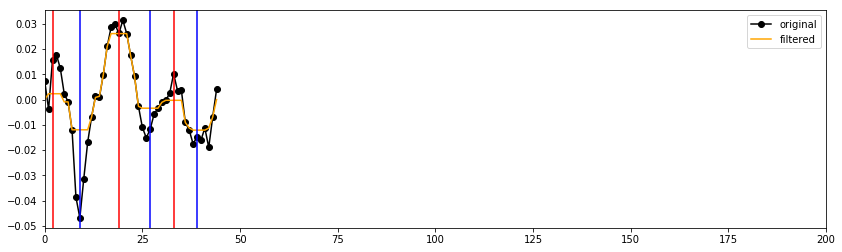

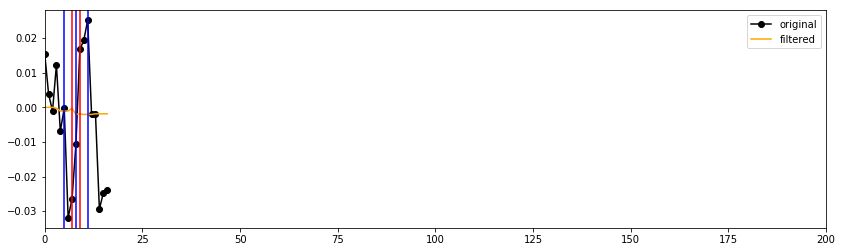

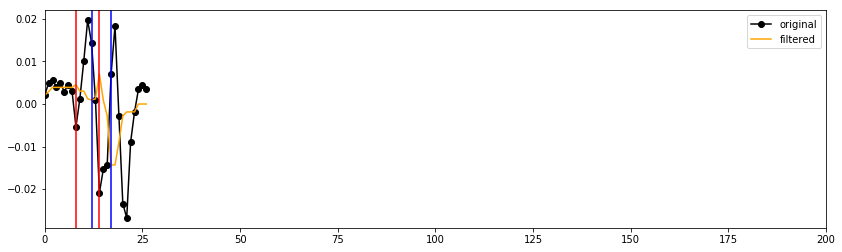

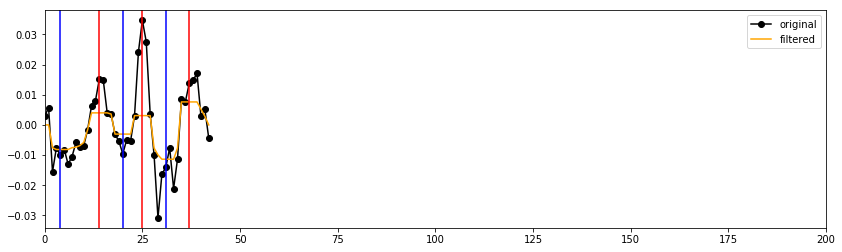

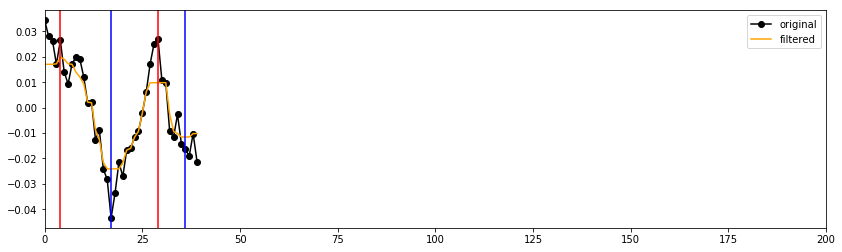

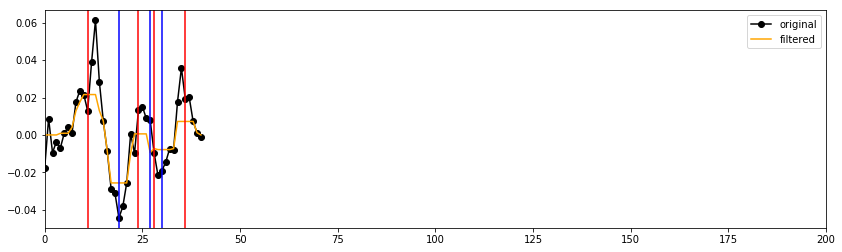

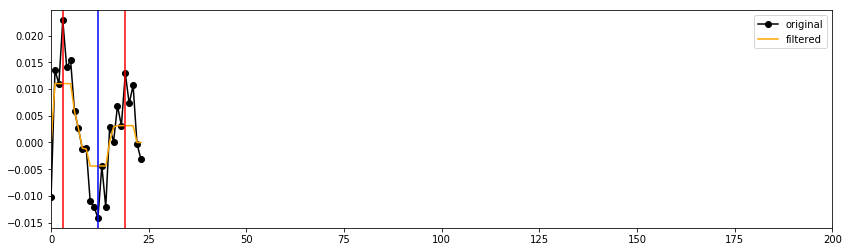

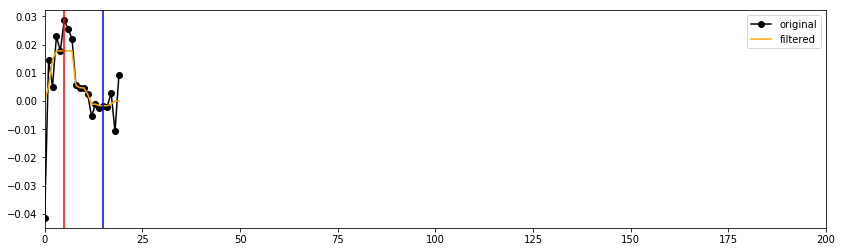

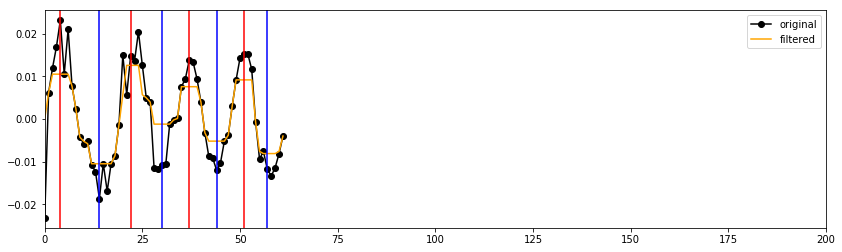

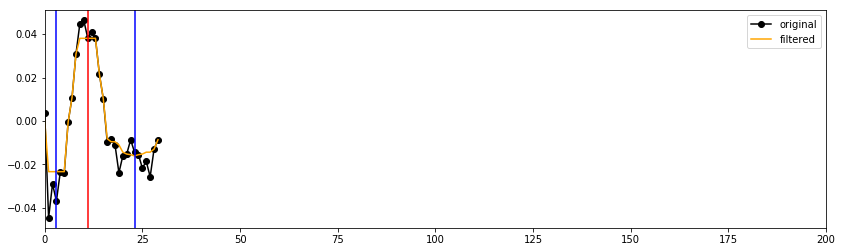

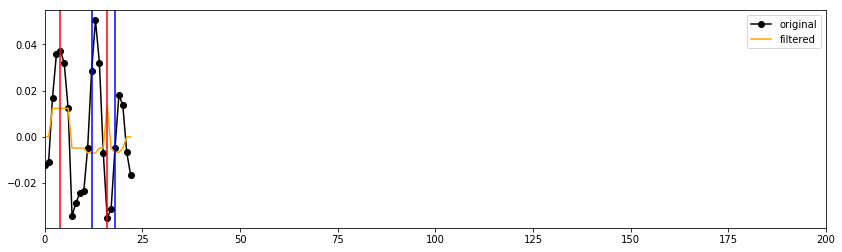

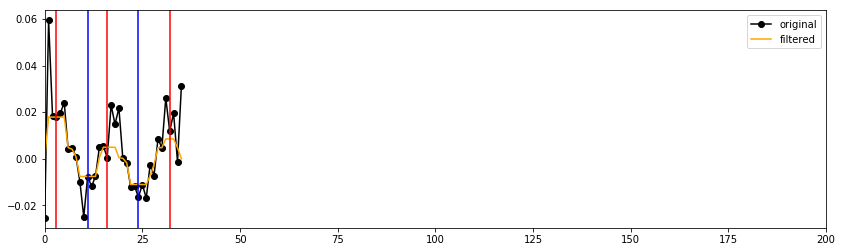

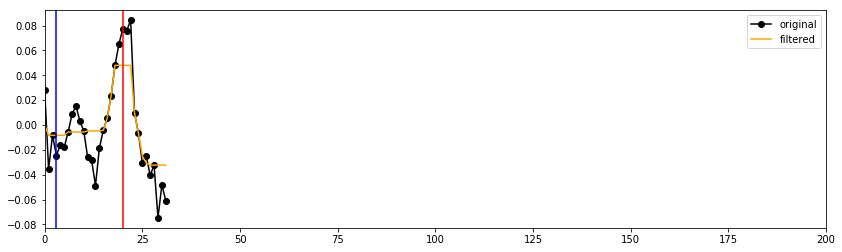

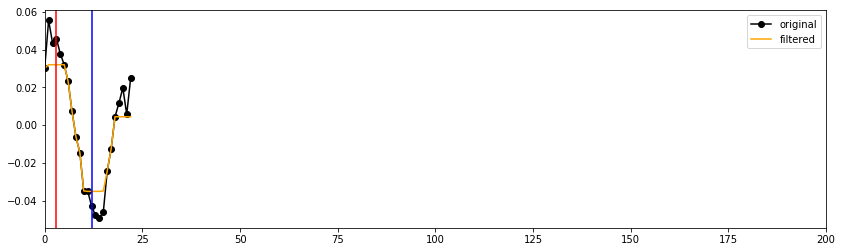

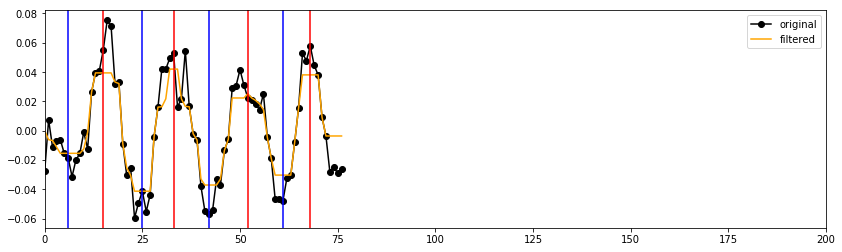

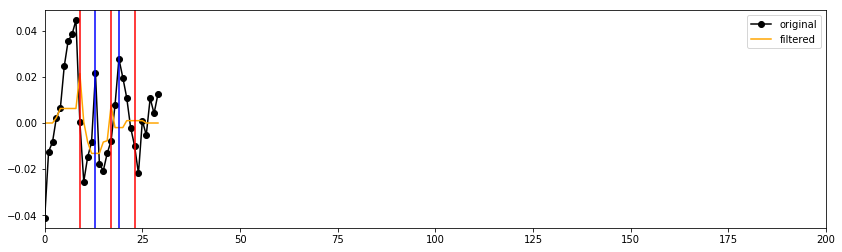

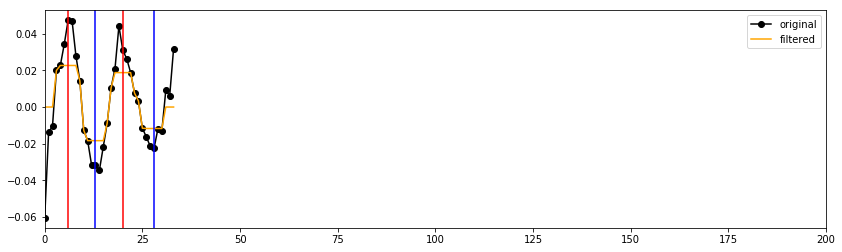

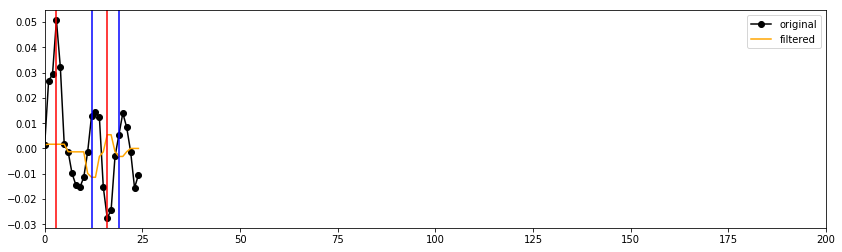

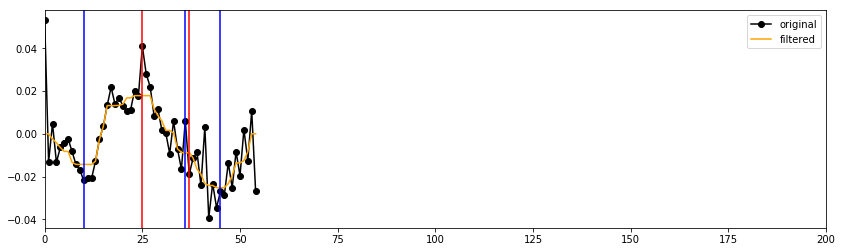

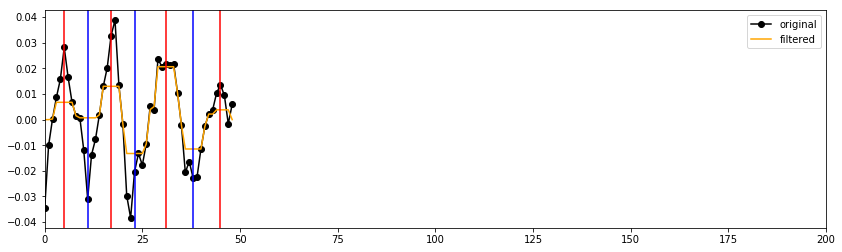

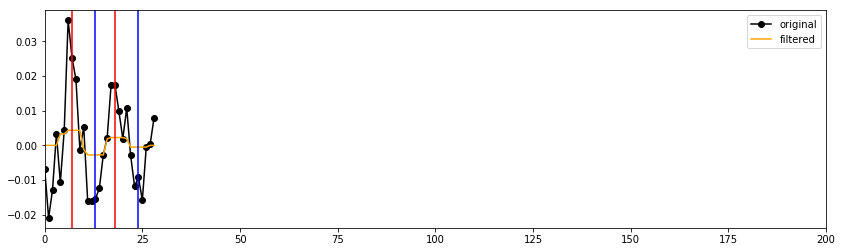

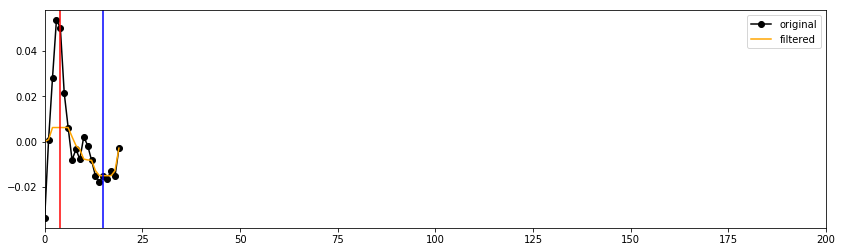

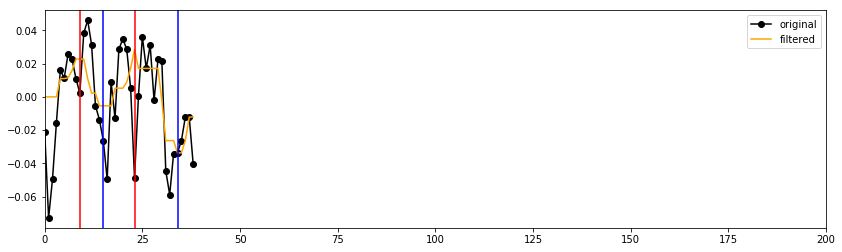

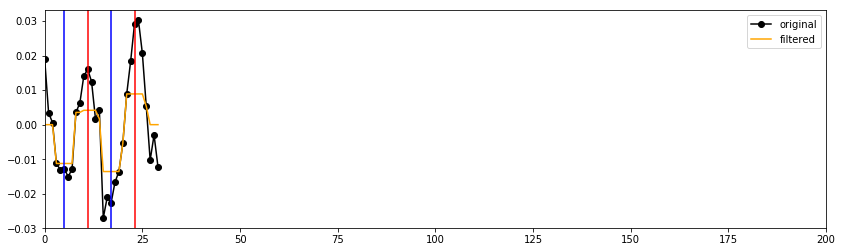

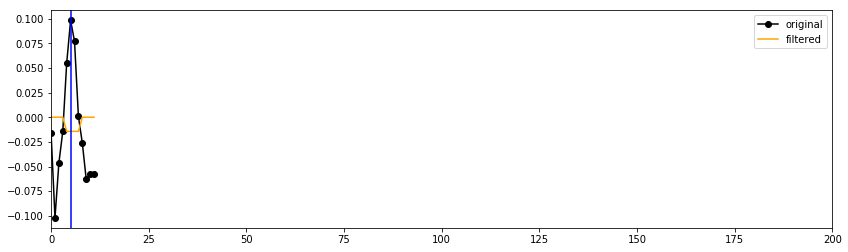

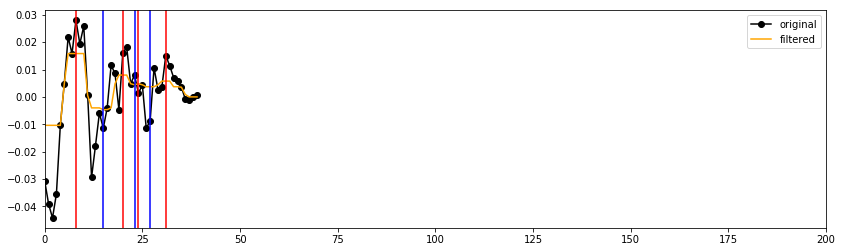

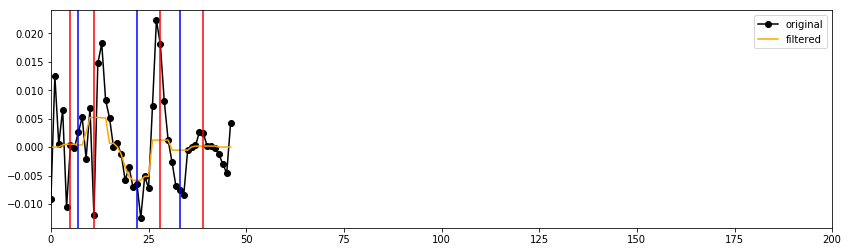

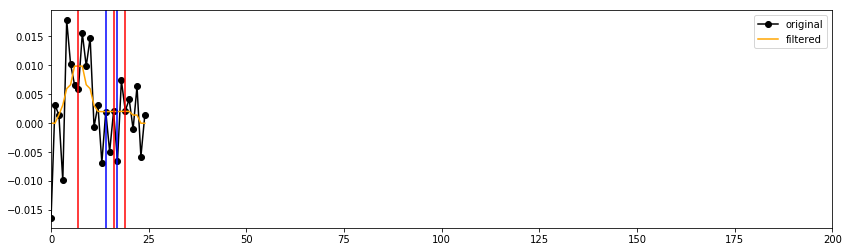

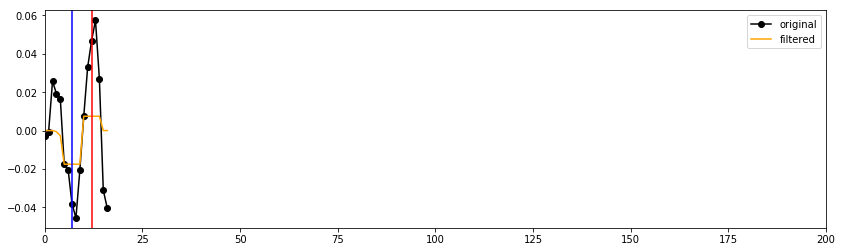

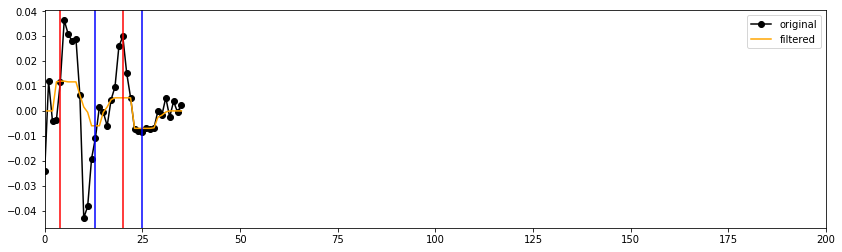

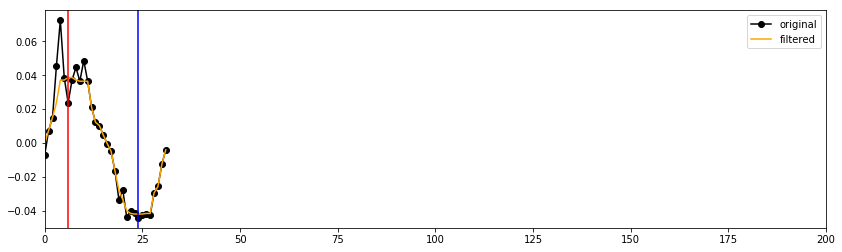

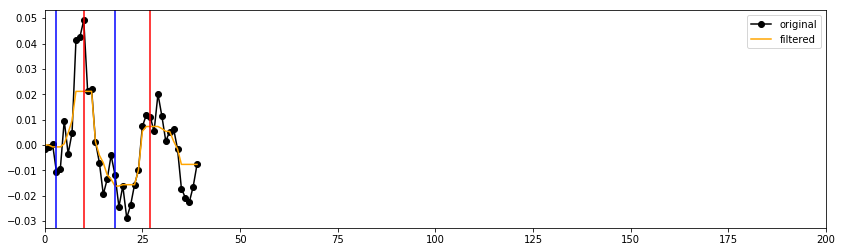

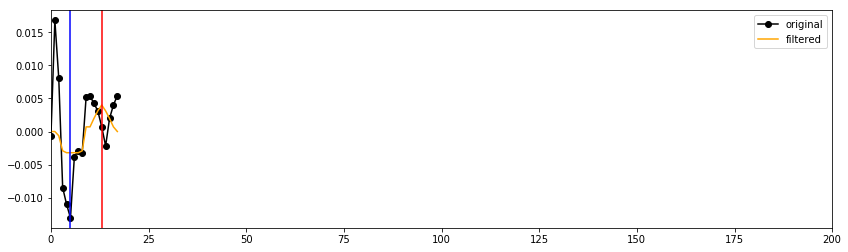

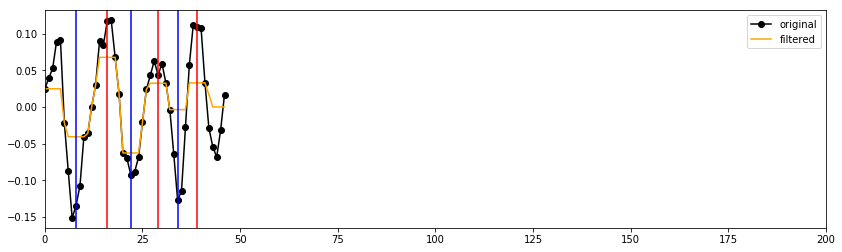

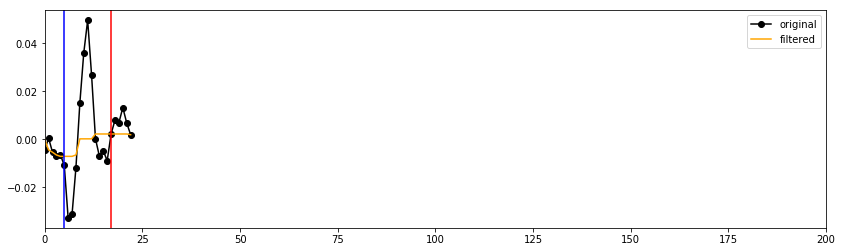

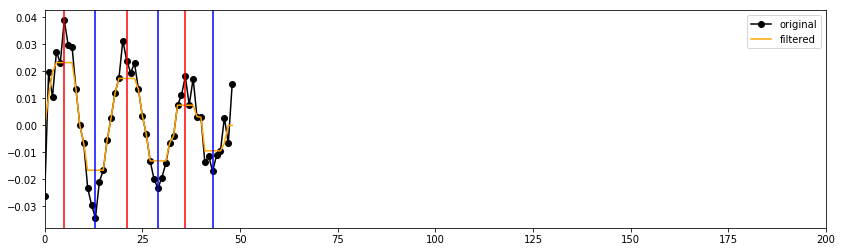

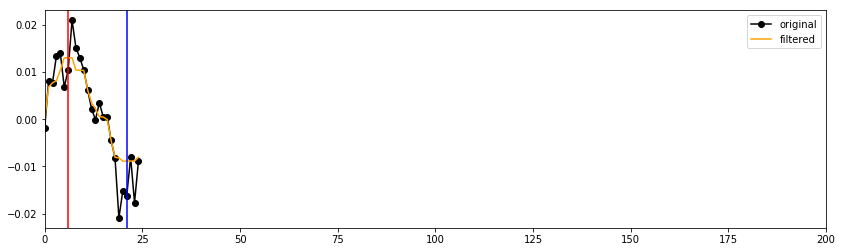

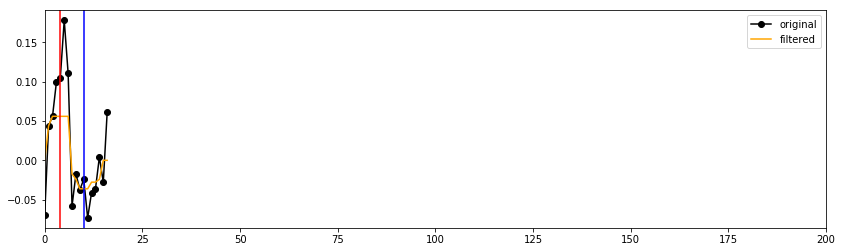

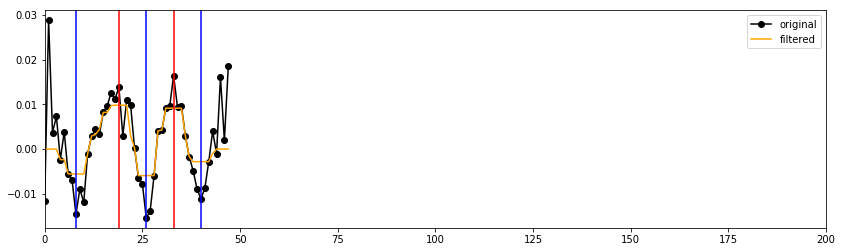

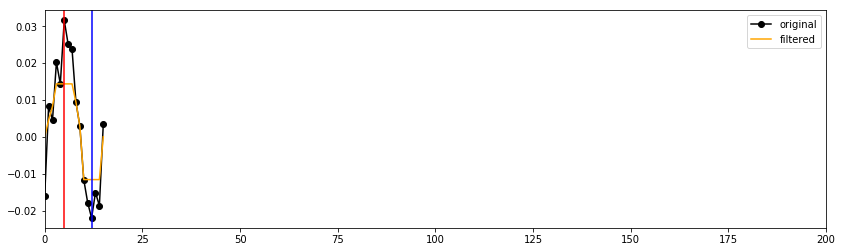

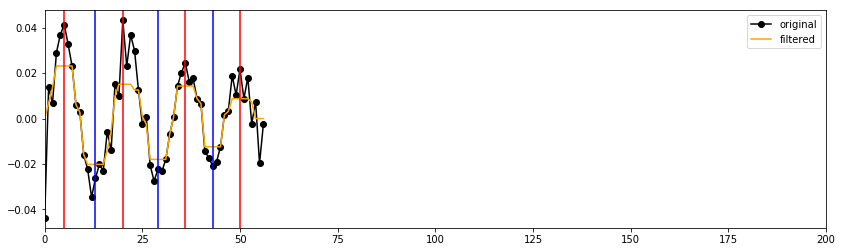

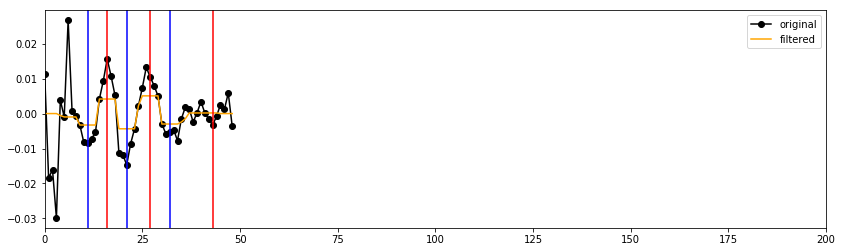

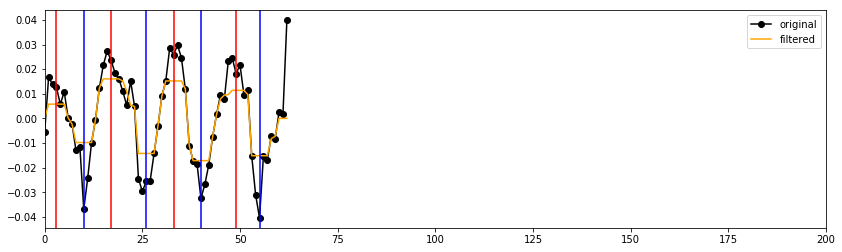

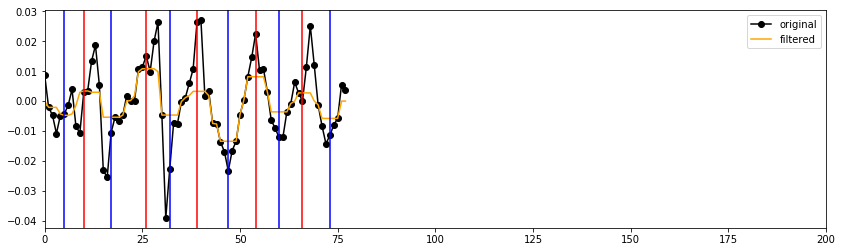

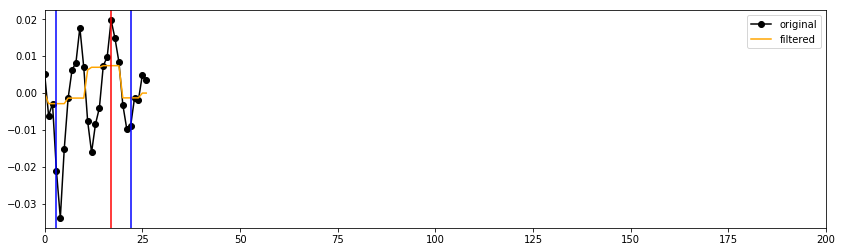

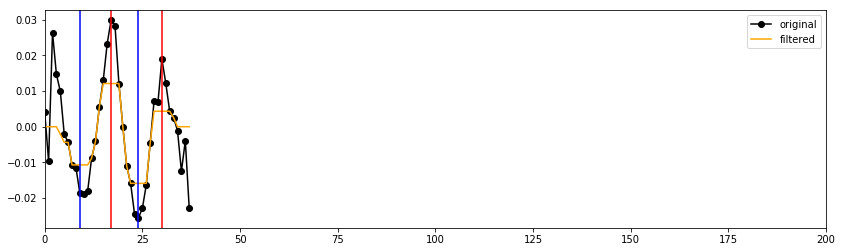

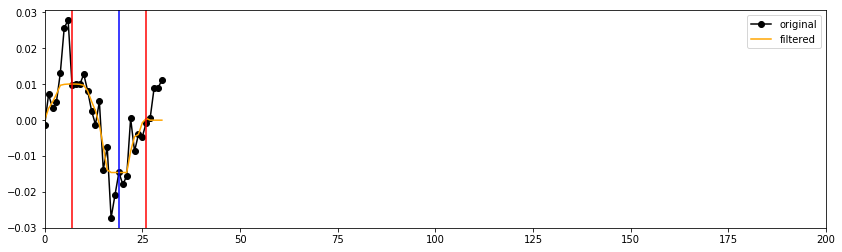

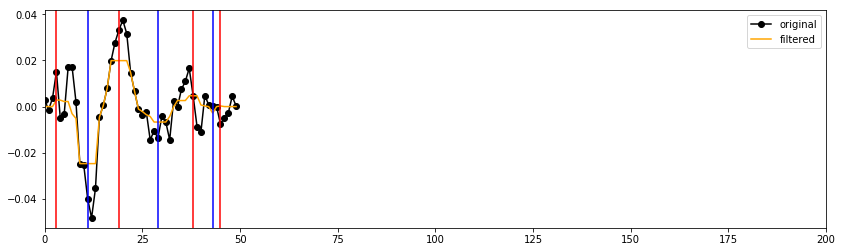

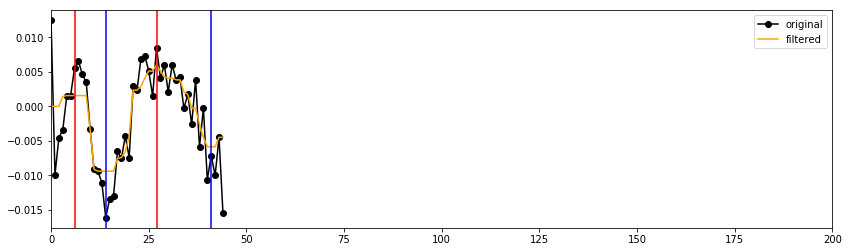

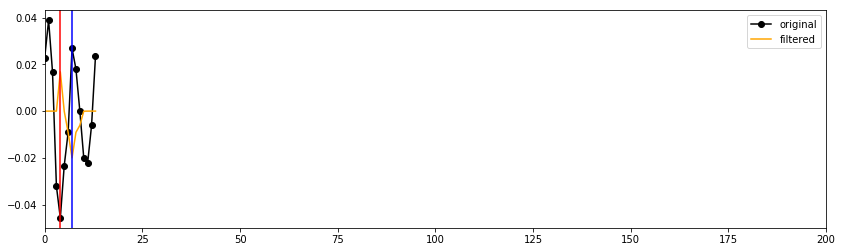

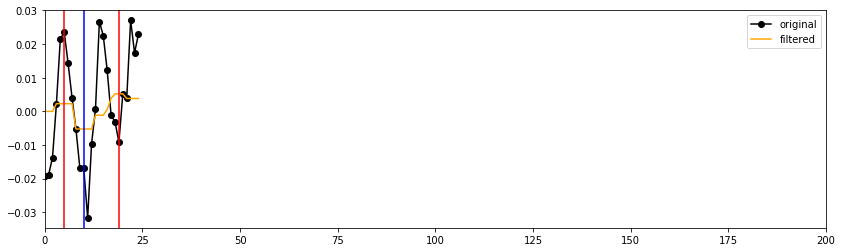

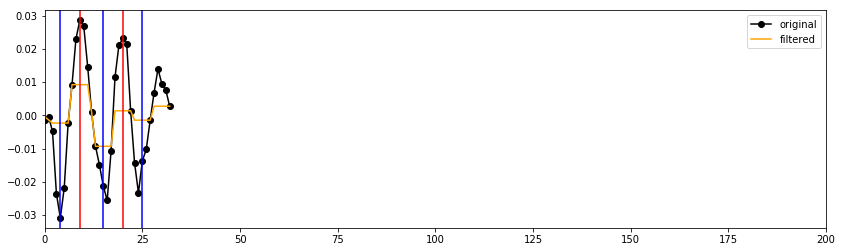

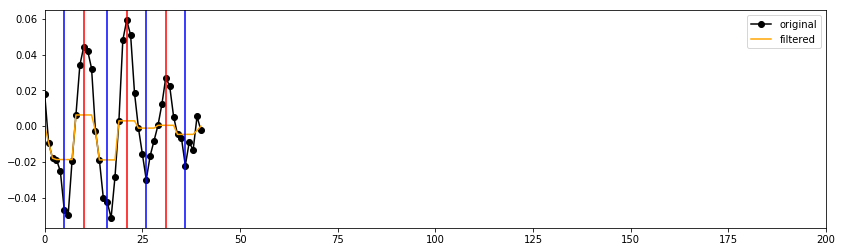

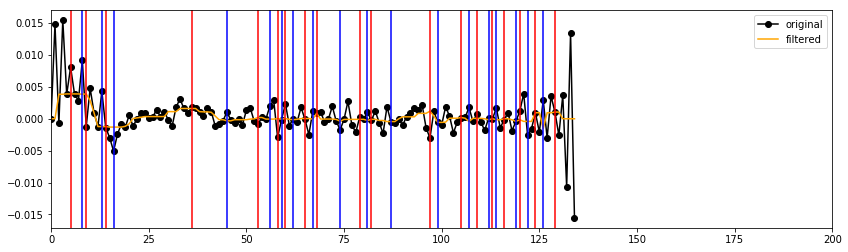

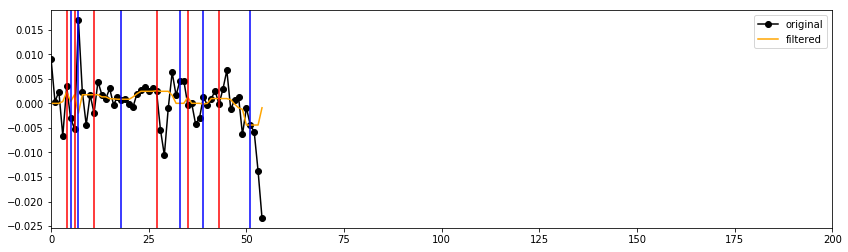

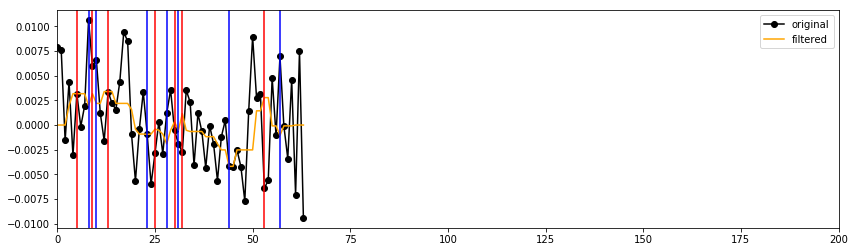

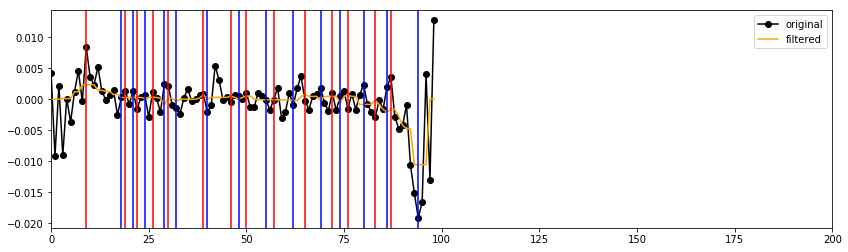

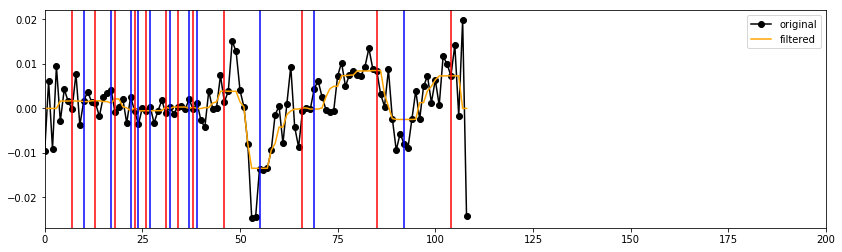

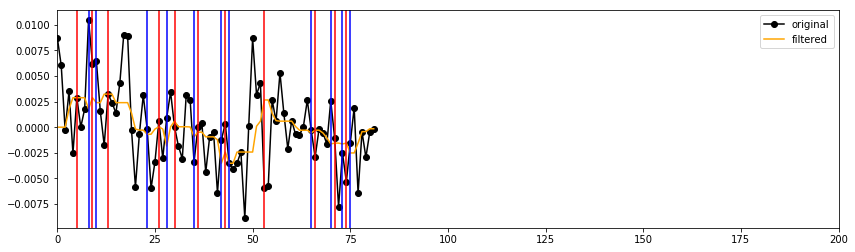

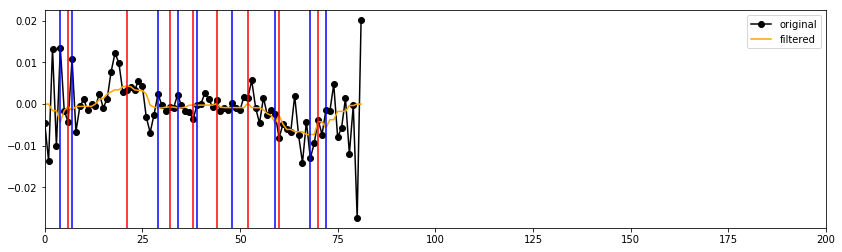

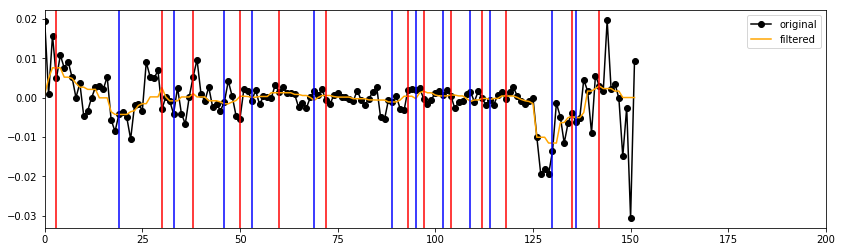

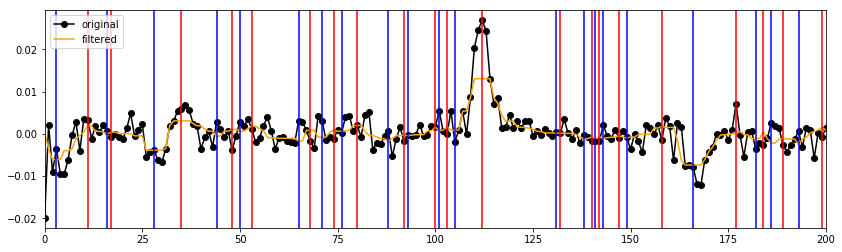

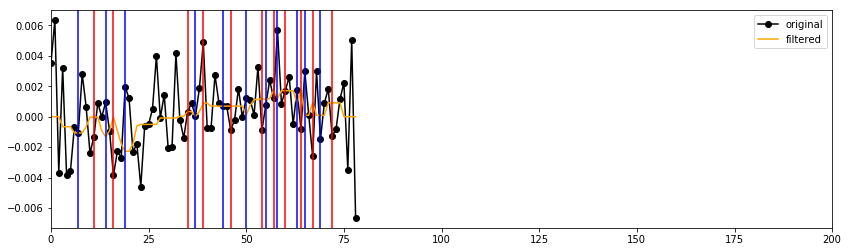

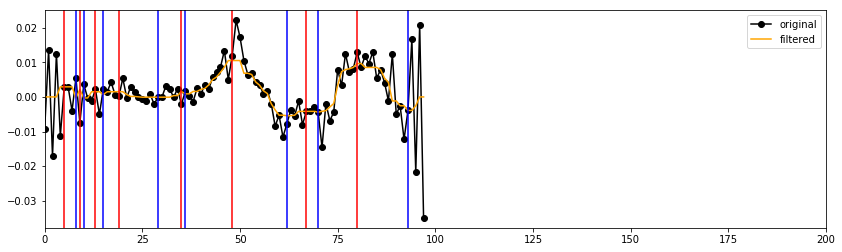

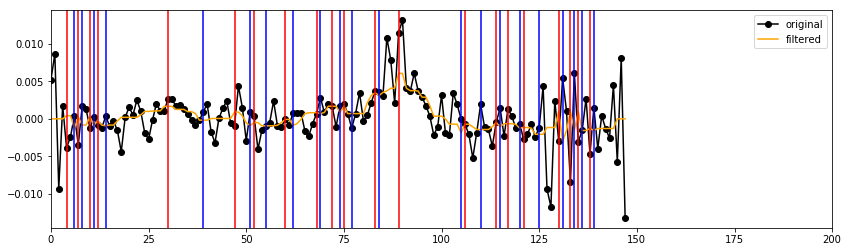

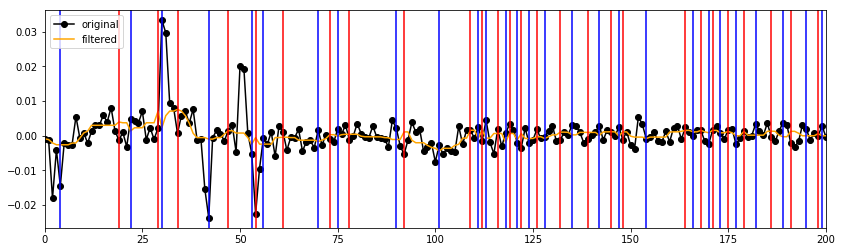

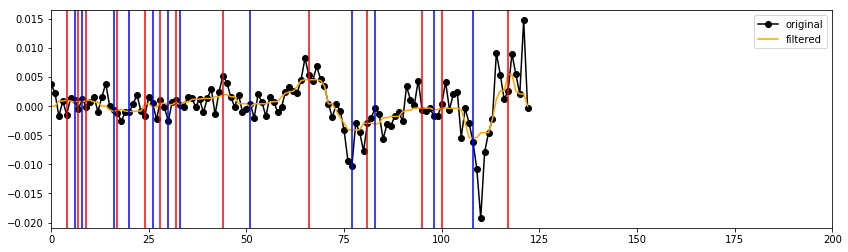

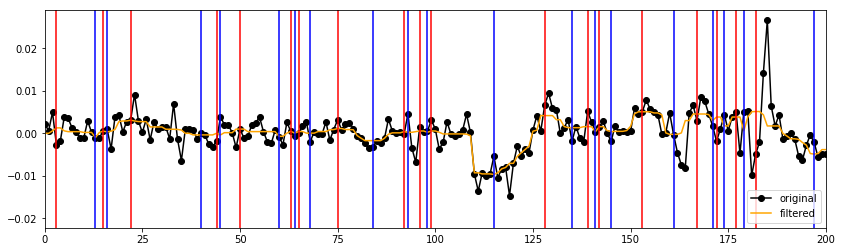

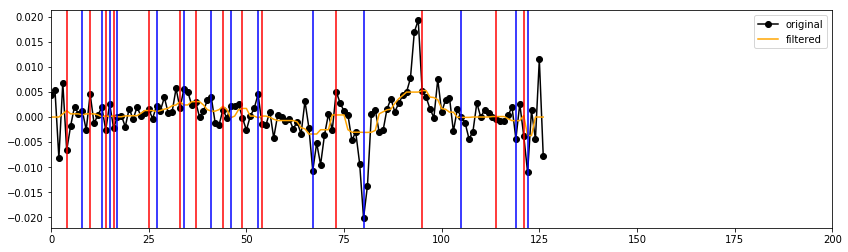

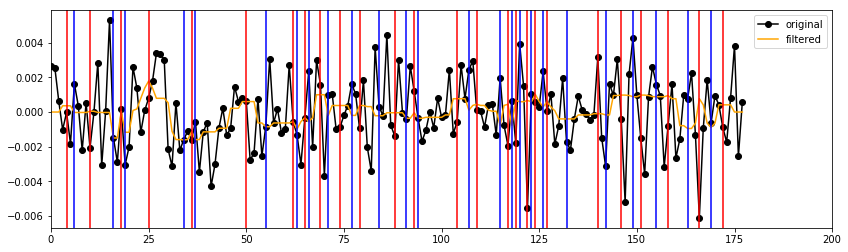

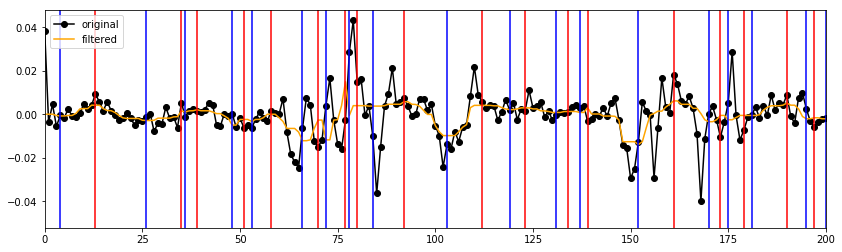

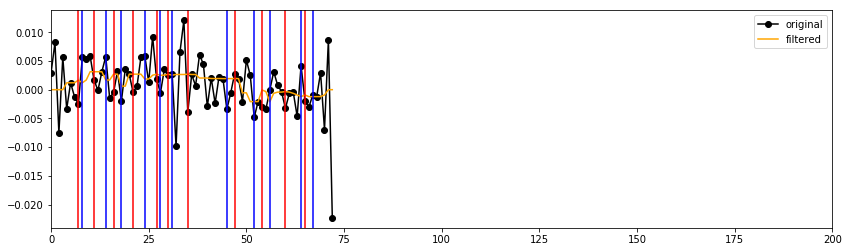

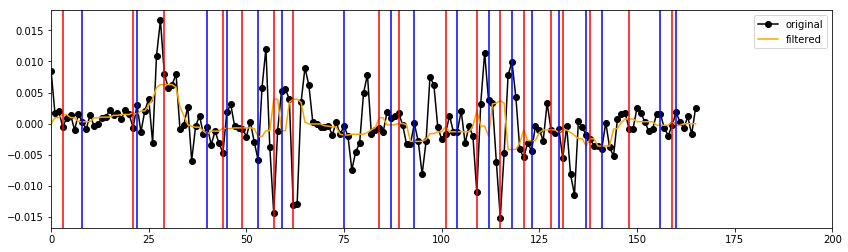

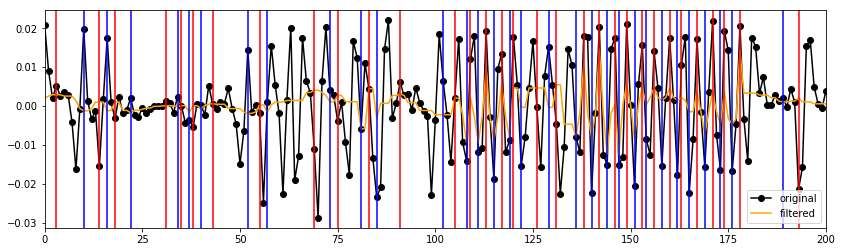

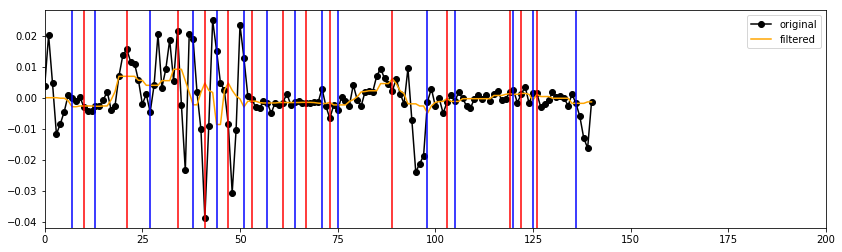

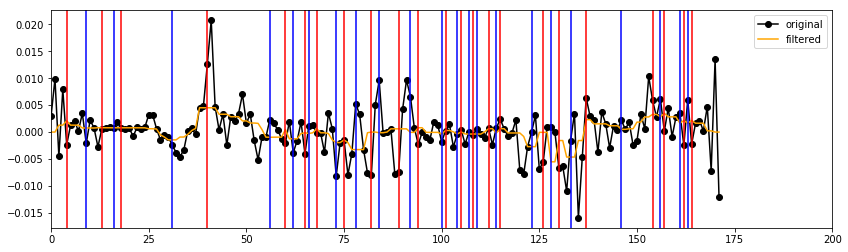

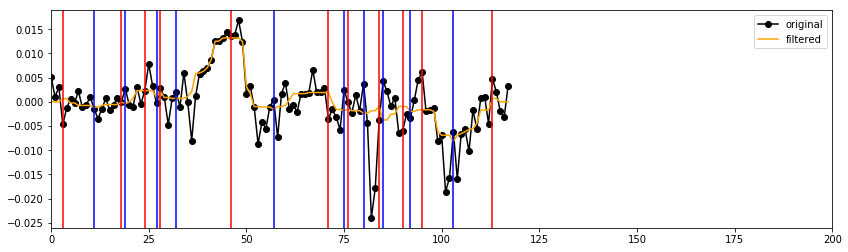

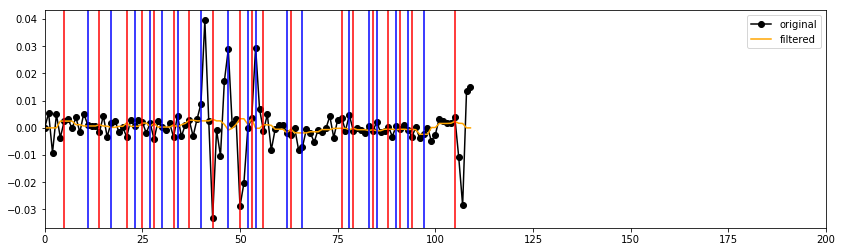

In [22]:
nod_x_widths,   nod_x_heights, avg_N_w, avg_N_h   = get_peaks_params(head_class='nod',   angle_type=angle_type_prefix+'x', derivative=0)
other_x_widths, other_x_heights, avg_O_w, avg_O_h = get_peaks_params(head_class='other', angle_type=angle_type_prefix+'x', derivative=0)


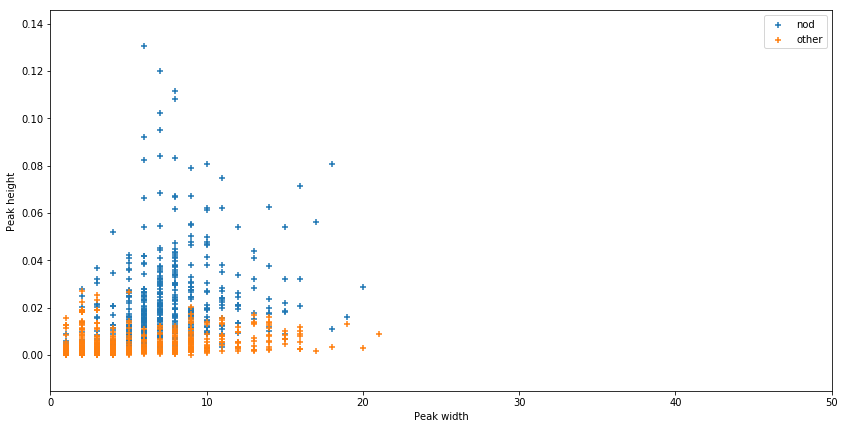

In [23]:
# PER-PEAK
# width and height/width

plt.figure(figsize=(14, 7))
plt.scatter(nod_x_widths, nod_x_heights, label='nod', marker='+')
plt.scatter(other_x_widths, other_x_heights, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
plt.xlim(0.0, 50)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

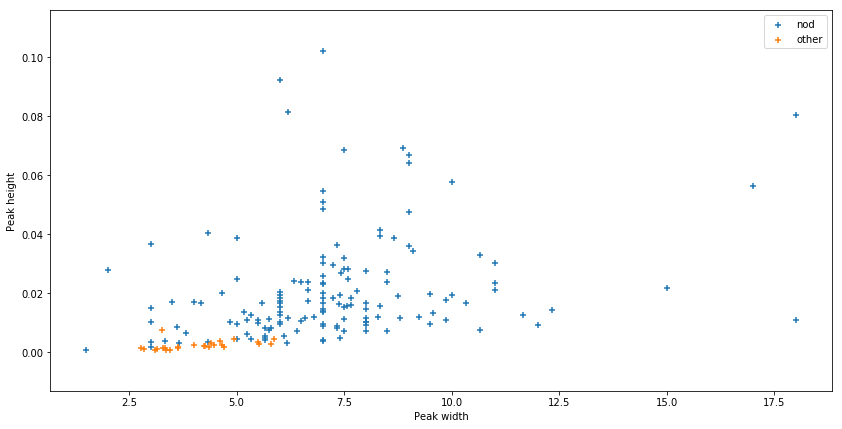

In [25]:
# average width per recording
# average height per recording

plt.figure(figsize=(14, 7))
plt.scatter(avg_N_w, avg_N_h, label='nod', marker='+')
plt.scatter(avg_O_w, avg_O_h, label='other', marker='+')
plt.xlabel('Peak width')
plt.ylabel('Peak height')
# plt.xlim(0.0, 40)
# plt.ylim(0.0, 0.005)
plt.legend()
plt.show()

In [26]:
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

n_neighbors = 5

random_state = 37

# Stack data
X = np.column_stack((avg_O_w + avg_N_w, avg_O_h + avg_N_h))
y = [0] * len(avg_O_w) + [1] * len(avg_N_w)

# Shuffle data
X, y = shuffle(X, y, random_state=random_state)

print(X.shape, len(y))

(171, 2) 171


In [27]:
# BOUNDARIES

target_names = ['other', 'nod']

kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
kNN.fit(X, y) 

y_pred = kNN.predict(X)

print(classification_report(y, y_pred, target_names=target_names))


print(f"Accuracy {kNN.score(X, y)}")

              precision    recall  f1-score   support

       other       0.72      0.52      0.60        25
         nod       0.92      0.97      0.94       146

   micro avg       0.90      0.90      0.90       171
   macro avg       0.82      0.74      0.77       171
weighted avg       0.89      0.90      0.89       171

Accuracy 0.9005847953216374


(0.000739219333334297, 0.1007392193333343)

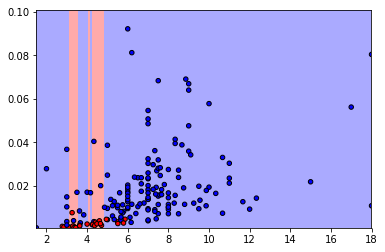

In [28]:
from matplotlib.colors import ListedColormap

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .02  # step size in the mesh

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = kNN.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [14]:
n_neighbors_range = range(1, 25)
for n_neighbors in n_neighbors_range:
    kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    kNN.fit(X, y) 
    print(n_neighbors, kNN.score(X, y))

1 1.0
2 0.9473684210526315
3 0.9473684210526315
4 0.9122807017543859
5 0.9005847953216374
6 0.9005847953216374
7 0.9064327485380117
8 0.9005847953216374
9 0.9005847953216374
10 0.8888888888888888
11 0.8771929824561403
12 0.8830409356725146
13 0.8830409356725146
14 0.8771929824561403
15 0.8713450292397661
16 0.8713450292397661
17 0.8771929824561403
18 0.8713450292397661
19 0.8596491228070176
20 0.8654970760233918
21 0.8538011695906432
22 0.8538011695906432
23 0.8771929824561403
24 0.8538011695906432
